# Complete functional mapping of NHP vaccine-elicited antibody lineages that target the fusion peptide of HIV
### Adam S. Dingens,  Julie Overbaugh, and Jesse D. Bloom
### In collaboration with the Kwong and Mascola groups at the NIH VRC

Experiments analyzed here were performed by Adam Dingens in the [Bloom lab](http://research.fhcrc.org/bloom/en.html) and [Overbaugh lab](https://research.fhcrc.org/overbaugh/en.html) in the summer of 2018.  

Here, we use mutational antigenic profiling to comprehensively map escape from macaque vaccine-elicited antibodies lineages. 
These are:
> * `106B6`, `106E6`, and `110D12`; clonally related mAbs from from NHP **DFPH**.
> * `DF1W203` and `DF1W314` (DF1W-a.01);  clonally related mAbs from from NHP **DF1W**.
> * `OPV12` and `OPV20`;  mAbs from from NHP **OPV**. I beleive these are not clonally related?
> * `17D4` (A12V163-17D4); from NHP **A12V163**, which has very limited breadth  (~3%). 

 We use **BG505.T332N** mutant Env virus libraries. Importnantly, this is sequence matched to most of the immunogens, which were BG505 Fp and BG505 SOSIP trimer (though sometimes a different trimer boost was used). The generation and characterization of the BG505 mutant virus libraires is described in detail in [Haddox, Dingens et al. eLife 2017](https://elifesciences.org/articles/34420). 

[Dingens et al. Plos Pathogens 2018](https://journals.plos.org/plospathogens/article?id=10.1371/journal.ppat.1007159) details mutational antigenic profiling of the template bnAb `N123-VRC34.01` and the murine vaccine-elicited antibodies `2712-vFP16.02`, and `2716-vFP20.01`.  [Dingens et al. Cell Host & Microbe 2017](http://dx.doi.org/10.1016/j.chom.2017.05.003) explains HIV mutational antigenic proifling in detail. 

Here, we use [dms_tools2](https://jbloomlab.github.io/dms_tools2/) to analyze the data.  This notebook processes the Illumina deep sequencing data, and then analyzes the selection in the context of the antibody. 

The barcoded subamplicon Illumina sequencing approach is described in detail [here](https://jbloomlab.github.io/dms_tools2/bcsubamp.html), and `differential selection` is described [here](https://jbloomlab.github.io/dms_tools2/diffsel.html).

## Import `Python` modules, define widely used functions
Set `use_existing` to `yes` below if you want to use any existing output, and `no` if you want to re-generate all output.

In [1]:
import os
import glob
import pandas as pd
from IPython.display import display, HTML
import dms_tools2
import dms_tools2.plot
import dms_tools2.sra
import dms_tools2.utils
import dms_tools2.diffsel
from dms_tools2.ipython_utils import showPDF
import rpy2
import rpy2.robjects 
import dms_tools2.rplot

import numpy as np
import pylab as plt
from colour import Color
print("Using dms_tools2 version {0}".format(dms_tools2.__version__))
# results will go in this directory
resultsdir = './results/' 
if not os.path.isdir(resultsdir):
    os.mkdir(resultsdir)
    
# CPUs to use, -1 means all available
ncpus = 14

# do we use existing results or generate everything new?
use_existing = 'yes'

Using dms_tools2 version 2.2.9


## Download the sequencing data from the Sequence Read Archive
Here we download sequencing data for each sample from the [Sequence Read Archive](http://www.ncbi.nlm.nih.gov/sra). Sample names specificy if they are mutant (mut) or wildtype (wt), as well as virus (virus) or DNA (DNA). The _#_ is which replicate (1, 2, and 3). The replicate notation that matches the [description of these libraries](https://elifesciences.org/articles/34420). If a sample is antibody selected, it also has the antibody and `ug/mL` concentration. There is metadata available from the SRA, and the dictionary below also specifies the accession number of each sample.

They reads were submitted as SRA submission [SUB4503475](https://submit.ncbi.nlm.nih.gov/subs/sra/SUB4503475/overview#) with SRA accession numbers `SRR7818016-SRR7818050` on Sep 10, 2018. The BioProject ID is `PRJNA490294`.

We download these files using the [dms_tools2.sra.fastqFromSRA](https://jbloomlab.github.io/dms_tools2/dms_tools2.sra.html) function from the dms_tools2 Python API. Note that the call to this function below uses two external programs that are not part of dms_tools2, and which you therefore must install externally on the computer that you are using:
1. The fastq-dump program from the SRA Toolkit. If you do not already have this toolkit installed, you will need to install a relatively recent version.
2. The Aspera Connect program for rapid downloads. You need both the executable ascp and an Aspera Key file. Installing Aspera Connect and a key can be somewhat complex, so if you do not want to do this then just set aspera=None in the command below and fastq-dump will do the downloads (albeit more slowly).



In [ ]:
samples = pd.DataFrame.from_records(
        [('BG505_mut_virus_1b_DF1W314-60ug','SRR7818035'),
        ('BG505_mut_virus_rep2c_17D4-3500ug','SRR7818036'),
        ('BG505_wt_virus_1b','SRR7818037'),
        ('BG505_mut_virus_rep2c_DF1W203-275ug','SRR7818038'),
        ('BG505_mut_virus_1b','SRR7818031'),
        ('BG505_mut_virus_rep2c_17D4-4200ug','SRR7818032'),
        ('BG505_mut_virus_rep2c_110D12-400ug','SRR7818033'),
        ('BG505_mut_virus_1b_DF1W203-130ug','SRR7818034'),
        ('BG505_mut_virus_1b_106E6-375ug','SRR7818039'),
        ('BG505_mut_virus_rep2c_DF1W314-60ug','SRR7818040'),
        ('BG505_wt_virus_rep2c','SRR7818021'),
        ('BG505_mut_virus_rep2c_OPV20-1750ug','SRR7818022'),
        ('BG505_mut_virus_rep3c_17D4-5000ug','SRR7818023'),
        ('BG505_mut_virus_rep2c_110D12-700ug','SRR7818024'),
        ('BG505_mut_virus_rep2c_OPV12-4000ug','SRR7818025'),
        ('BG505_wt_virus_rep3c','SRR7818026'),
        ('BG505_mut_virus_2b','SRR7818027'),
        ('BG505_wt-DNA_1','SRR7818028'),
        ('BG505_wt_virus_3b','SRR7818029'),
        ('BG505_mut_virus_rep3c_DF1W314-160ug','SRR7818030'),
        ('BG505_mut_virus_rep2c','SRR7818048'),
        ('BG505_wt-DNA_3','SRR7818047'),
        ('BG505_mut_virus_rep3c_110D12-400ug','SRR7818050'),
        ('BG505_wt-DNA_2','SRR7818049'),
        ('BG505_mut_virus_rep3c_OPV20-1750ug','SRR7818044'),
        ('BG505_mut_virus_rep3c_OPV12-3600ug','SRR7818043'),
        ('BG505_wt_virus_2b','SRR7818046'),
        ('BG505_mut_virus_3b','SRR7818045'),
        ('BG505_mut_virus_rep3c_DF1W203-400ug','SRR7818042'),
        ('BG505_mut_virus_rep2c_DF1W314-80ug','SRR7818041'),
        ('BG505_mut_virus_rep3c','SRR7818019'),
        ('BG505_mut_virus_2b_106E6_375ug','SRR7818020'),
        ('BG505_mut_virus_1b_106B6-375ug','SRR7818017'),
        ('BG505_mut_virus_rep3c_DF1W314-80ug','SRR7818018'),
        ('BG505_mut_virus_2b_106B6_375ug','SRR7818016')],       
        columns=['name', 'run']
        )


fastqdir = 'results/FASTQ_files/'
print("Downloading FASTQ files from the SRA...")
dms_tools2.sra.fastqFromSRA(
        samples=samples,
        fastq_dump='fastq-dump', # valid path to this program on the Hutch server
        fastqdir=fastqdir,
        aspera=(
            '/app/aspera-connect/3.5.1/bin/ascp', # valid path to ascp on Hutch server
            '/app/aspera-connect/3.5.1/etc/asperaweb_id_dsa.openssh' # Aspera key on Hutch server
            ),
        )
print("Here are the names of the downloaded files now found in {0}".format(fastqdir))
display(HTML(samples.to_html(index=False)))

## Define samples from FASTQ_files

In [ ]:
#I will use this cell after I upload and re-download this data from the SRA. 
fastqdir = './results/FASTQ_files/'
R1fastqfilelist = (glob.glob("./results/FASTQ_files/*R1.fastq.gz"))
R1fastqfilelist_df = pd.DataFrame(R1fastqfilelist)
R1fastqfilelist_df.columns = ['R1']
R1fastqfilelist_df.replace('./results/FASTQ_files/', '', regex=True, inplace=True)
R1fastqfilelist_df['name'] = R1fastqfilelist_df['R1']
R1fastqfilelist_df['name'].replace('_R1.fastq.gz', '', regex=True, inplace=True)
R1fastqfilelist_df['name'].replace('_', '-', regex=True, inplace=True)
R1fastqfilelist_df['name'].replace('\.', '-', regex=True, inplace=True)
R1fastqfilelist_df['name'].replace('BG505-', '', regex=True, inplace=True)

#R1fastqfilelist_df
display(HTML(R1fastqfilelist_df.to_html(index=False)))

In [2]:
#need to change this late
#fastqdir = '../FASTQ_files/'
#print(fastqdir)

In [14]:
R1fastqfilelist_df = pd.read_csv("./data/NHP_FP_samples.csv", header =0)
display(HTML(R1fastqfilelist_df.to_html(index=False)))

name,R1
mut-virus-1b-DF1W314-60ug,BG505_mut_virus_1b_DF1W314-60ug_R1.fastq.gz
mut-virus-2c-17D4-3500ug,BG505_mut_virus_rep2c_17D4-3500ug_R1.fastq.gz
wt-virus-1b,BG505_wt_virus_1b_R1.fastq.gz
mut-virus-2c-DF1W203-275ug,BG505_mut_virus_rep2c_DF1W203-275ug_R1.fastq.gz
mut-virus-1b,BG505_mut_virus_1b_R1.fastq.gz
mut-virus-2c-17D4-4200ug,BG505_mut_virus_rep2c_17D4-4200ug_R1.fastq.gz
mut-virus-2c-110D12-400ug,BG505_mut_virus_rep2c_110D12-400ug_R1.fastq.gz
mut-virus-1b-DF1W203-130ug,BG505_mut_virus_1b_DF1W203-130ug_R1.fastq.gz
mut-virus-1b-106E6-375ug,BG505_mut_virus_1b_106E6-375ug_R1.fastq.gz
mut-virus-2c-DF1W314-60ug,BG505_mut_virus_rep2c_DF1W314-60ug_R1.fastq.gz


## Process the FASTQ files to count the mutations for each sample
We used [barcoded-subamplicon](https://jbloomlab.github.io/dms_tools2/bcsubamp.html) sequencing to obtain high accuracy during the Illumina deep sequencing. We therefore use the [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html#dms2-batch-bcsubamp) program to analyze these data.

Running that program requires specifying a `--batchfile` that lists the samples, a wildtype `--refseq` to which we make alignments, and --alignspecs that tell us where the subamplicons should align. 
The batch file that we specify is printed by the cell below. The alignment specs need to be exactly correct for the subamplicons to align. We also do some trimming of the reads using the `--R1trim` and `--R2trim` parameters. 

The wildtype sequence of the BG505.W6.C2.T332N Env used in this experiment is in the file [./data/BG505.W6.C2.T332N_env.fasta](./data/BG505.W6.C2.T332N_env.fasta).
This sequence is based on GenBank accession number [DQ208458.1](https://www.ncbi.nlm.nih.gov/nucleotide/77025198?report=genbank&log$=nuclalign&blast_rank=1&RID=WMZ5XNUG014), with the introduced T332N mutation to knock in the glycan commonly targeted by V3/N332 class bnAbs. 

In [15]:
refseq = './data/BG505.W6.C2.T332N_env.fasta'
#sitestoinclude = "./data/BG505_sitestoinclude.csv"
sitemask = "./data/sitemask_BG505.txt"

# define subamplicon alignment specifications
alignspecs = ' '.join(['87,375,39,36', 
                       '376,666,36,39',
                       '663,954,33,41',
                       '955,1228,33,37',
                       '1228,1527,34,35',
                       '1527,1815,32,39',
                       '1816,2098,36,41'])

# counts and alignments placed in this directory
countsdir = os.path.join(resultsdir, 'codoncounts')
if not os.path.isdir(countsdir):
    os.mkdir(countsdir)
    
# write sample information to a batch file for dms2_batch_bcsubamplicons
countsbatchfile = os.path.join(countsdir, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(R1fastqfilelist_df[['name', 'R1']].to_html(index=False)))
R1fastqfilelist_df[['name', 'R1']].to_csv(countsbatchfile, index=False)

print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countsbatchfile} \
        --refseq {refseq} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 200 \
        --R2trim 170 \
        --minq 15 \
        --fastqdir {fastqdir} \
        --ncpus {ncpus} \
        --sitemask {sitemask} \
        --use_existing {use_existing} 
print("Completed dms2_batch_bcsubamp.")

Here is the batch file that we write to CSV format to use as input:


name,R1
mut-virus-1b-DF1W314-60ug,BG505_mut_virus_1b_DF1W314-60ug_R1.fastq.gz
mut-virus-2c-17D4-3500ug,BG505_mut_virus_rep2c_17D4-3500ug_R1.fastq.gz
wt-virus-1b,BG505_wt_virus_1b_R1.fastq.gz
mut-virus-2c-DF1W203-275ug,BG505_mut_virus_rep2c_DF1W203-275ug_R1.fastq.gz
mut-virus-1b,BG505_mut_virus_1b_R1.fastq.gz
mut-virus-2c-17D4-4200ug,BG505_mut_virus_rep2c_17D4-4200ug_R1.fastq.gz
mut-virus-2c-110D12-400ug,BG505_mut_virus_rep2c_110D12-400ug_R1.fastq.gz
mut-virus-1b-DF1W203-130ug,BG505_mut_virus_1b_DF1W203-130ug_R1.fastq.gz
mut-virus-1b-106E6-375ug,BG505_mut_virus_1b_106E6-375ug_R1.fastq.gz
mut-virus-2c-DF1W314-60ug,BG505_mut_virus_rep2c_DF1W314-60ug_R1.fastq.gz



Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


Now we look at the summary plots created by `dms2_batch_bcsubamp`. 
All of these files are found in the directory specified by --outdir, and with the prefix specified by summaryprefix. 
So we define them using this plot prefix plus the suffix for each plot.
Note that these files all refer to sites in sequential 1, 2, ... numbering of the BG505 sequence.

In [6]:
countsplotprefix = os.path.join(countsdir, 'summary')

The `*_readstats.pdf` plot below shows the statistics on the reads. This plot shows that most of the reads were retained, and a small fraction discarded because of low-quality barcodes. None failed the Illumina filter as those were already filtered out those when we downloaded from the SRA.

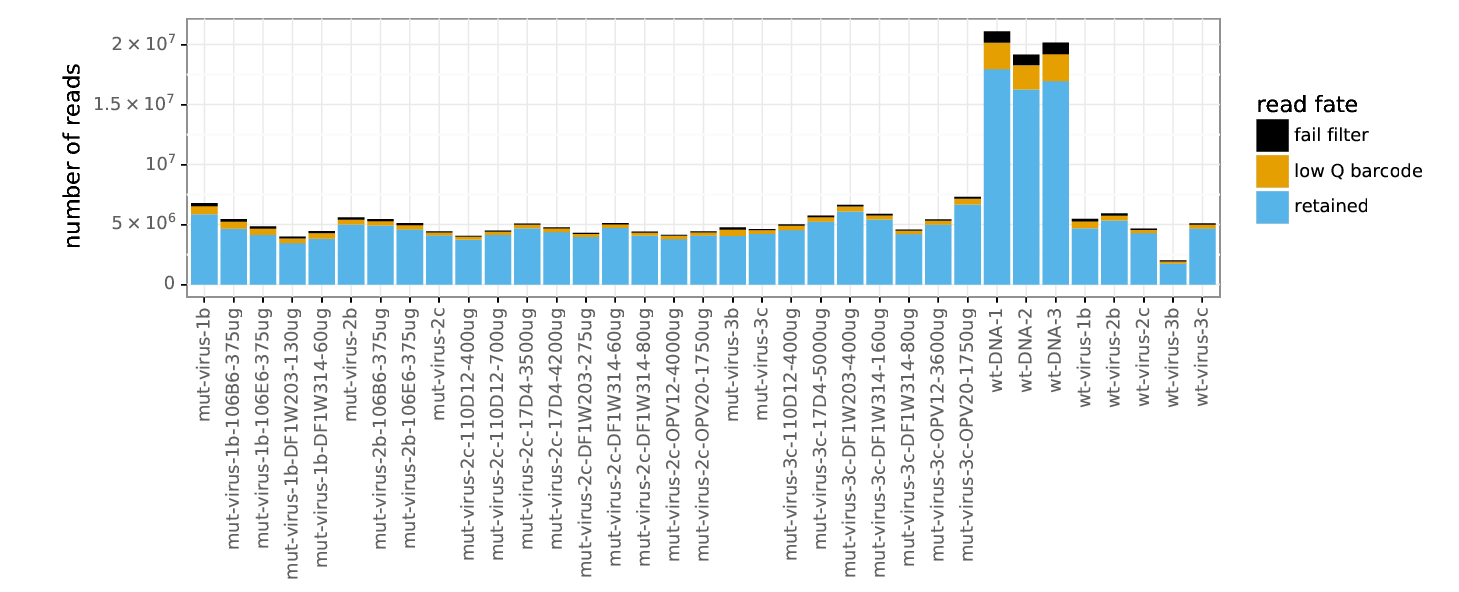

In [7]:
showPDF(countsplotprefix + '_readstats.pdf', width=600)

The `*_readsperbc.pdf` plot below shows how many times different barcodes were observed for each sample. Barcodes need to be observed multiple times to be useful for barcoded-subamplicon sequencing error correction.

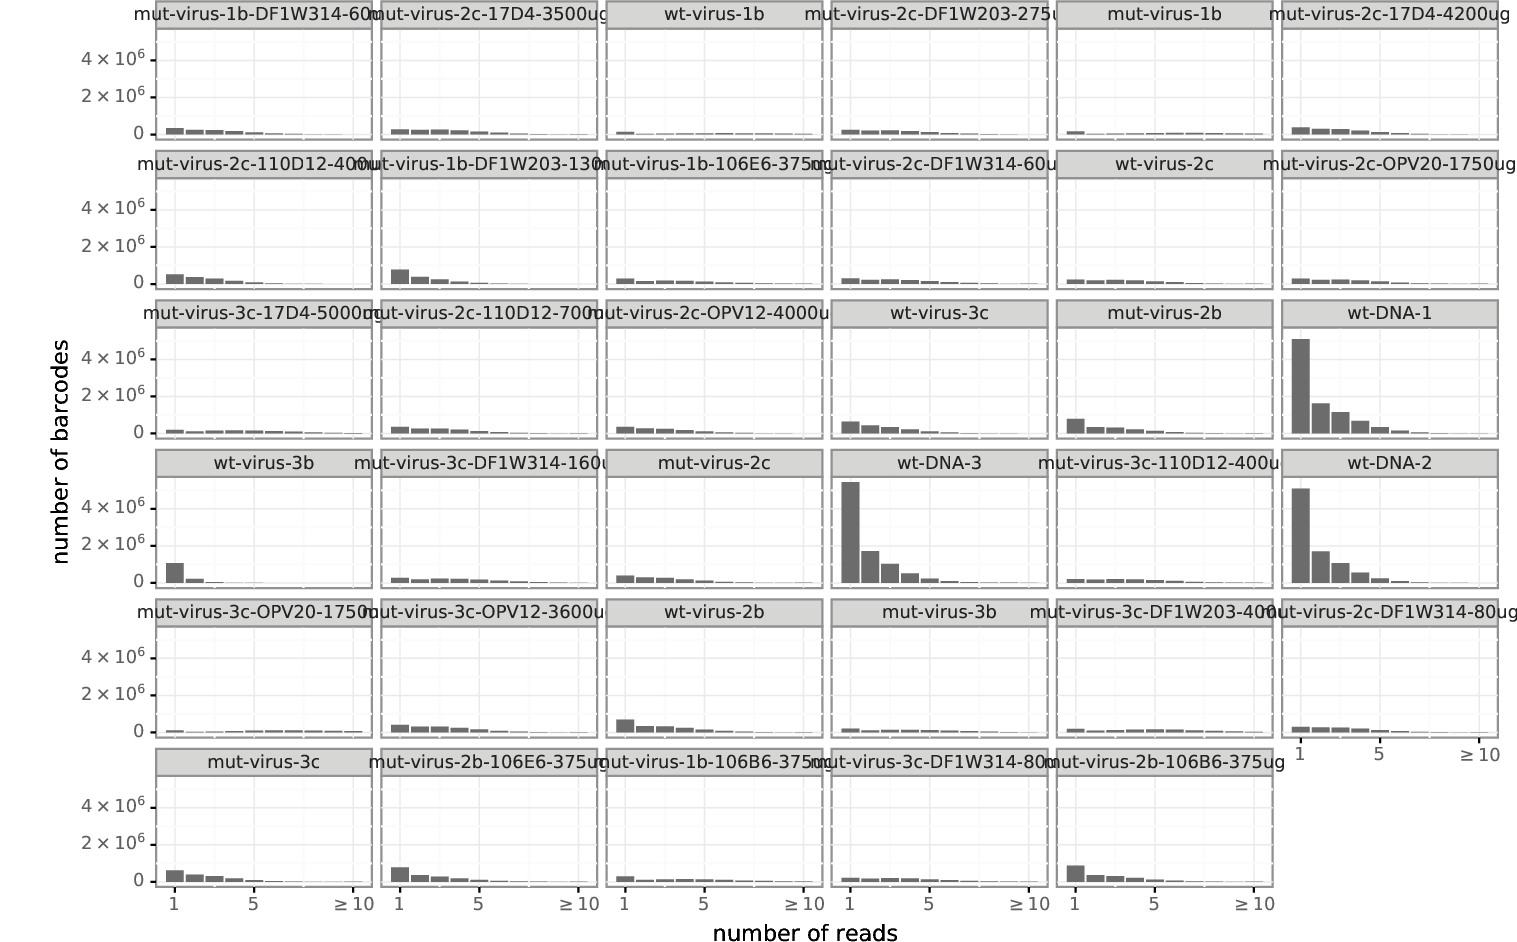

In [8]:
showPDF(countsplotprefix + '_readsperbc.pdf')

The `*_bcstats.pdf` plot below shows statistics on the barcodes. Some of the barcodes had to be discarded because they had too few reads (these are the single-read barcodes in the plot above), a small fraction with adequate reads were not alignable, and the rest aligned to the Env gene properly.
This plot and the one above suggest that probably could have gotten additional depth by sequencing more, since then we would have had more barcodes with multiple reads.

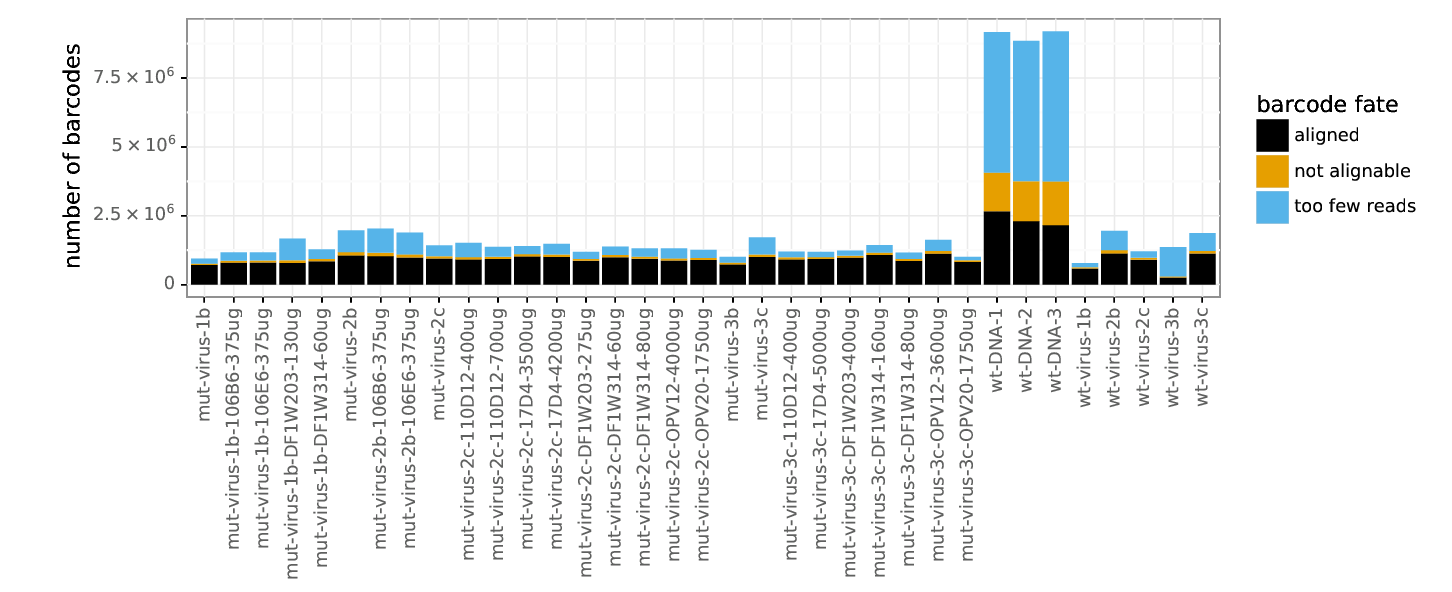

In [15]:
showPDF(countsplotprefix + '_bcstats.pdf', width=600)

The `*_depth.pdf` plot below shows the depth (number of called codons) at each site in the gene. 
For most of the samples, the depth across the gene is fairly uniform, indicating that the subamplicons were pooled fairly evenly.  
Note that some samples (in particular the mock samples) were intentionally sequenced to higher depth than the antibody-selected samples, as we expect to see more diversity in the mock samples. 

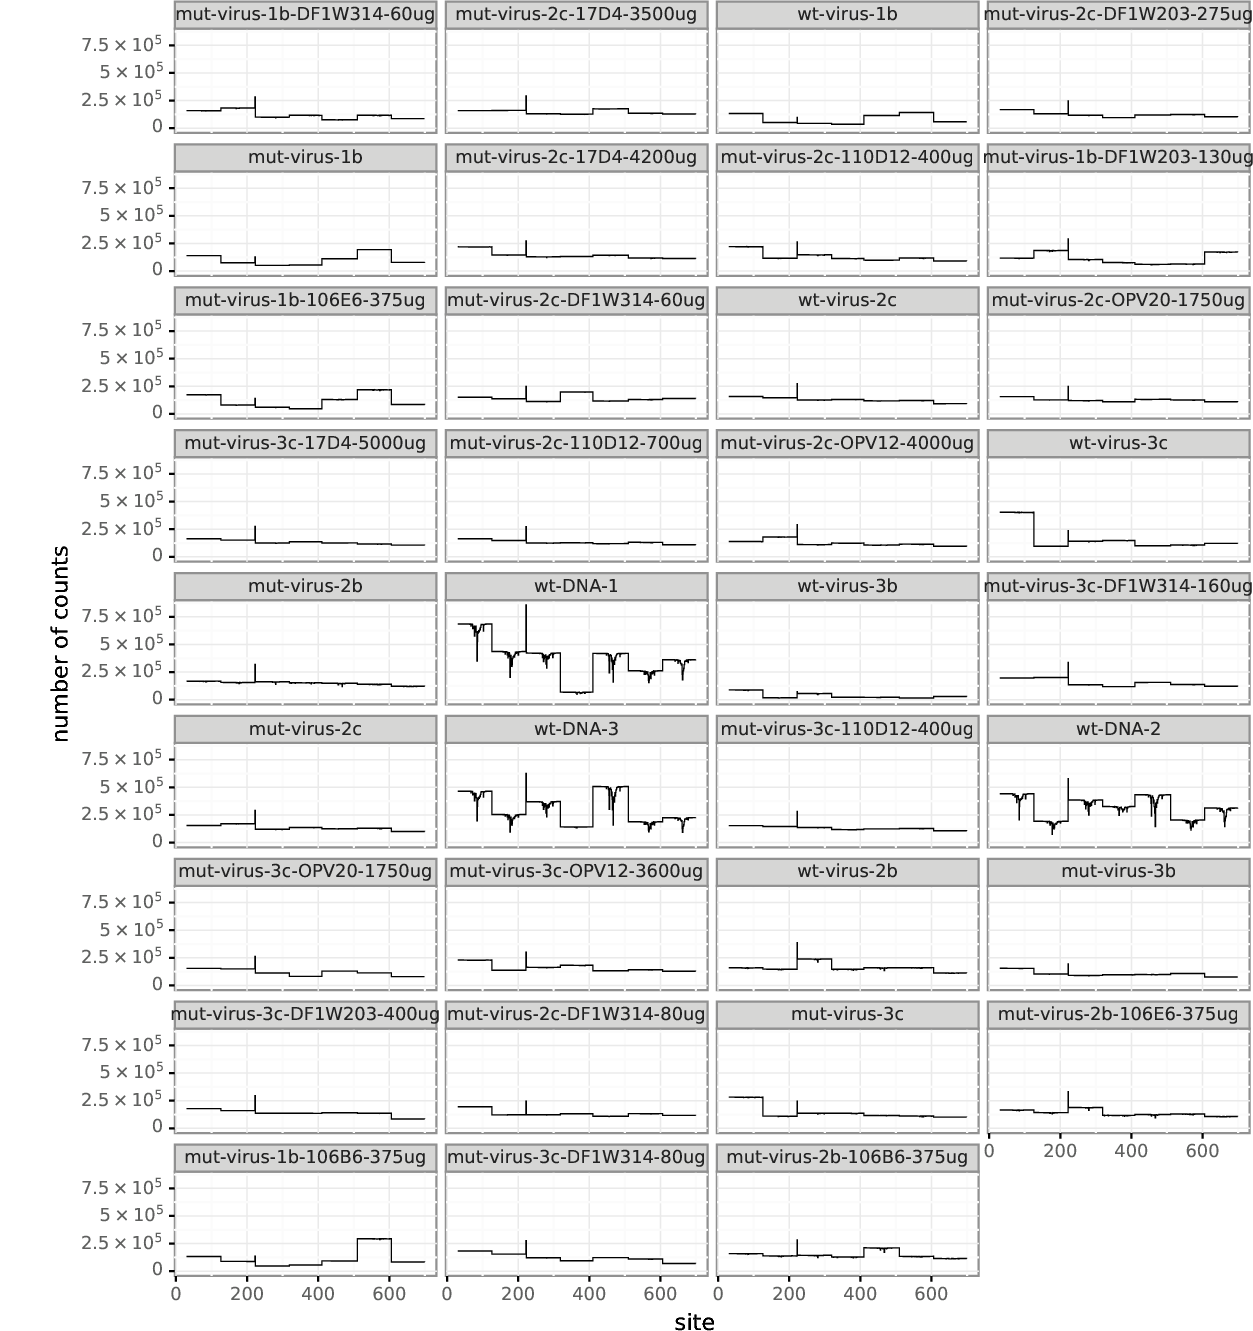

In [16]:
showPDF(countsplotprefix + '_depth.pdf')

The `*_mutfreq.pdf` plot below shows the per-codon frequency of mutations at each site. 
For each antibody-selected sample, we see a few sites of clear peaks in mutation frequency. 
These peaks tend to occur at the same sites in different replicates, and so presumably represent the sites where antibody-escape mutations are selected. 
There are no such peaks for the mock sample since there is no antibody selection to favor specific mutations.
Note also that the gene was not mutagenized or sequenced in the signal peptide or cytoplasmic tail.

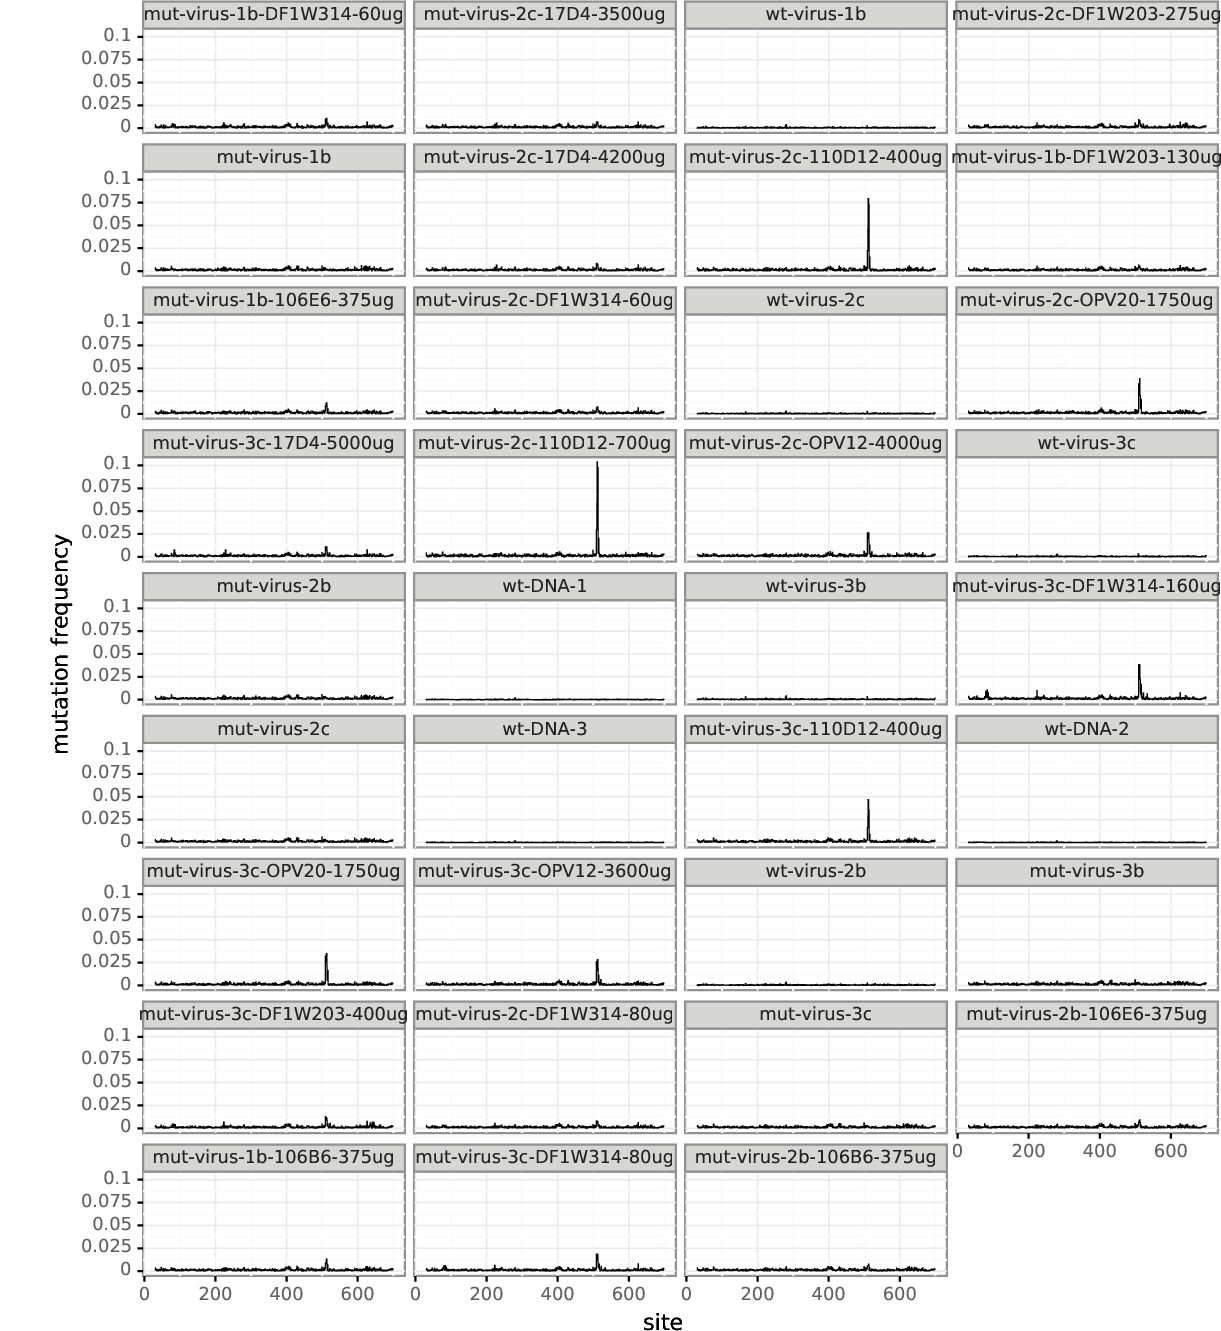

In [17]:
showPDF(countsplotprefix + '_mutfreq.pdf')

The `*_codonmuttypes.pdf` plot below shows the per-codon frequency of nonsynonymous, synonymous, and stop codon mutations across the entire gene. For the antibody selected samples, we see an overall increase in the per-codon mutation frequency due to very strong selection for variants with escape mutations.

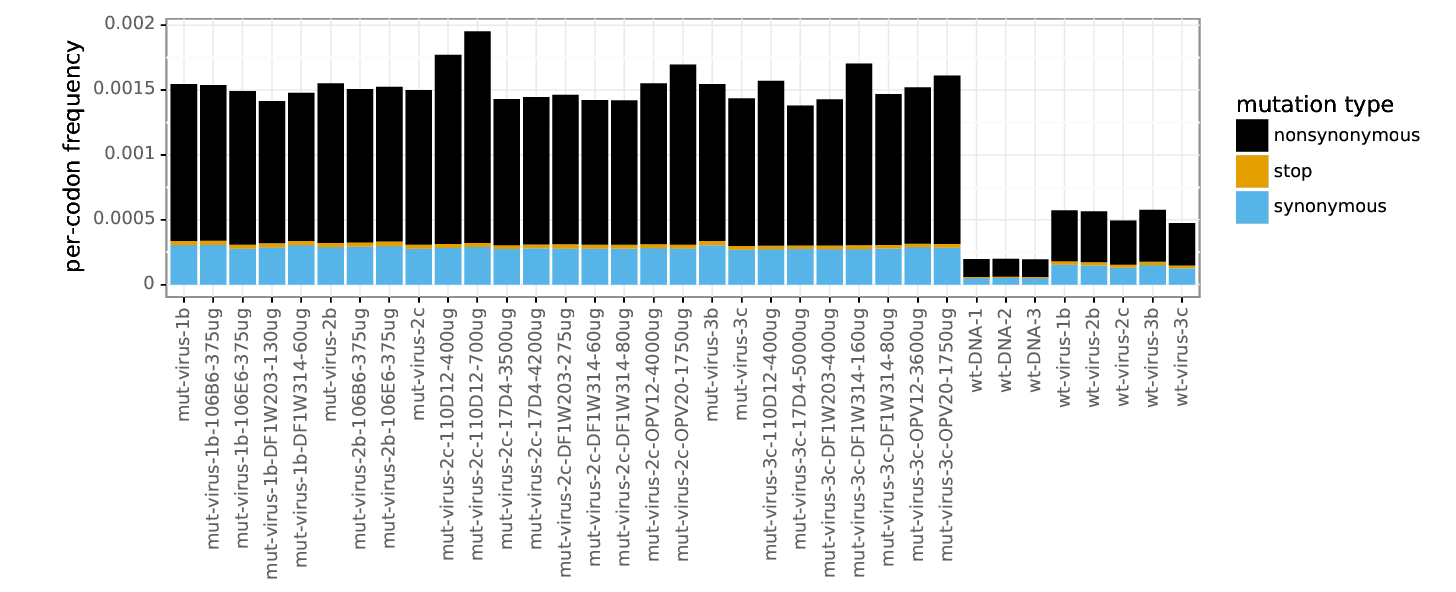

In [18]:
showPDF(countsplotprefix + '_codonmuttypes.pdf', width=600)

The `*_codonntchanges.pdf` plot below shows same data as above but categorizes codon mutations by the number of nucleotides that are changed (e.g., ATG to AAG changes 1 nucleotide, ATG to AAC changes 2 nucleotides, and ATG to CAC changes 3 nucleotides).

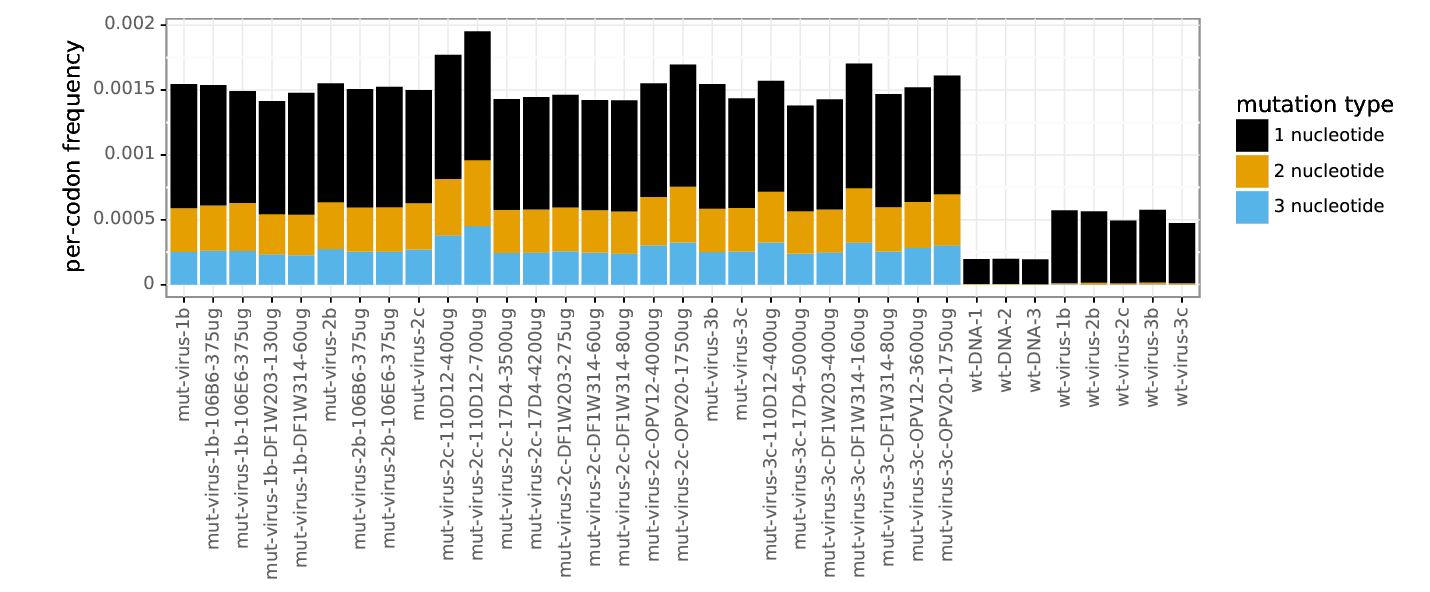

In [19]:
showPDF(countsplotprefix + '_codonntchanges.pdf', width=600)

The `*_singlentchanges.pdf` plot below shows the frequency of each type of nucleotide change among only codon mutations with one nucleotide change. This plot is mostly useful to check if there is a large bias in which mutations appear. In particular, if you are getting oxidative damage (which causes G to T mutations) during the library preparation process, you will see a large excess of C to A or G to T mutations (or both). There is not much oxidative damage in the samples plotted below, which mostly have a fairly even distribution of nucleotide changes.

We do see that transitions (G <-> A and C <-> T) are a bit more common than most of the other types of mutations (all of which are transversions). This is expected, since [PCR based sources of mutations are expected to preferentially introduce transitions](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3720931/). 

This plot would also be important to examine any sign of APOBEC hypermutation (also G <-> A, with preferences for specific motifs) occuring in the HIV genome. One of the reasons we selected the SupT1.R5 cell line was because [there is very little of the APOBEC proteins expressed in  a subclone of SupT1 cells](https://www.ncbi.nlm.nih.gov/pubmed/20308164). In the viral samples, there does appear to be an increase in G to A and C to T mutations. However, we passaged WT virus in these cells and confirmed there were not signs of extensive APOBEC hypermutation in hotspot motifs via deep sequencing of env after passaging. Thus, we do not think there is extensive APOBEC hypermutation in our data, and this increase certain types of mutations in the viral samples is likely due to bias in the viral reverse transcription.

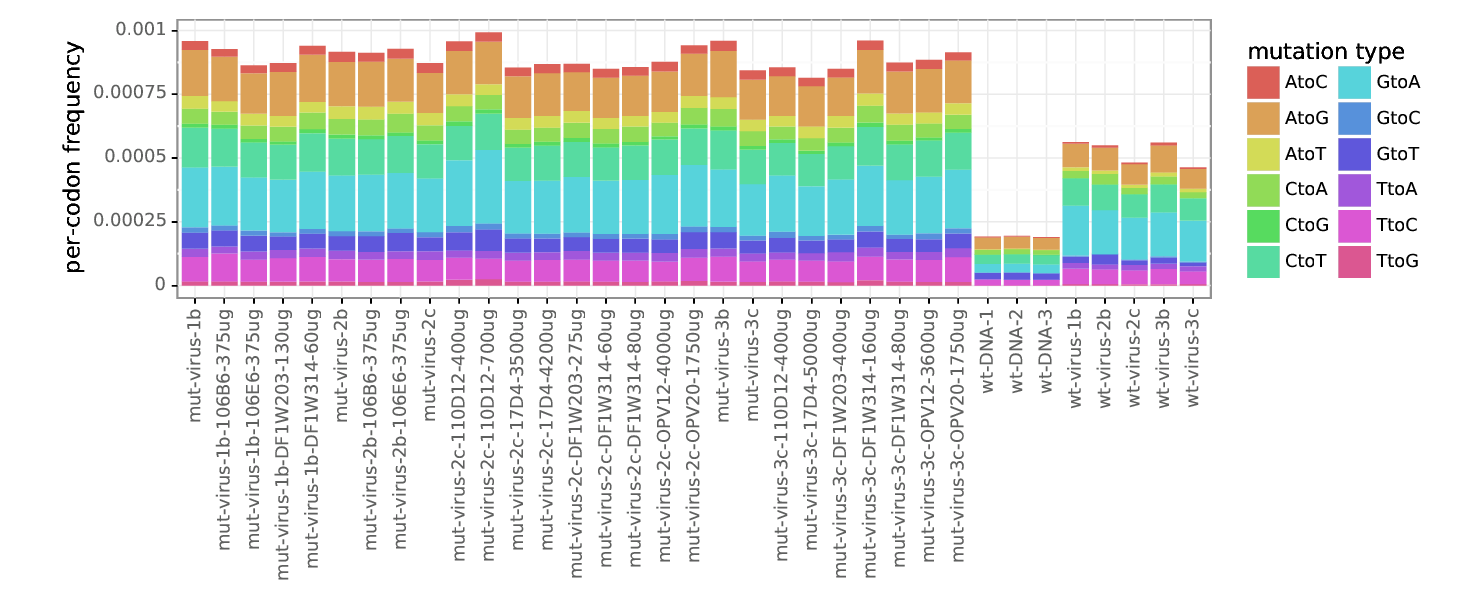

In [20]:
showPDF(countsplotprefix + '_singlentchanges.pdf', width=600)

## Renumber codon counts to HXB2 numbering 
The standard numbering scheme for HIV Env is the [HXB2 numbering scheme](https://www.hiv.lanl.gov/content/sequence/HIV/REVIEWS/HXB2.html).
The file [./data/BG505_to_HXB2_numbering.txt](./data/BG505_to_HXB2_numbering.txt) gives the mapping from sequential 1, 2, ... numbering of the BG505 protein sequence to the HXB2 numbering scheme. 
This file was generated by aligning the HXB2 sequence [taken from Genbank](http://www.ncbi.nlm.nih.gov/protein/1906385) with the [BG505C2.T332N](./data/BG505.W6.C2.T332N_env.fasta) sequence at the protein sequence level. 
Insertions relative to HXB2 are given letter suffixes as [described here](http://www.hiv.lanl.gov/content/sequence/HIV/REVIEWS/HXB2.html).

Additionally, not all residues in BG505 Env were mutagenized. 
The N-terminal signal peptide and the C-terminal cytoplasmic tail were excluded because they seem likely to affect expression level. 
These sites are not listed in the renumbering file, and so are dropped when we do the re-numbering.

To do the re-numbering, we use the [dms_tools2.utils.renumberSites](https://jbloomlab.github.io/dms_tools2/dms_tools2.utils.html#dms_tools2.utils.renumberSites) function from the [dms_tools Python API](https://jbloomlab.github.io/dms_tools2/api.html) to create a new directory that contains all of the re-numbered files with the same name as in the original codon counts directory produced above.

In [16]:
renumberedcountsdir = os.path.join(resultsdir, 'renumberedcounts')

In [17]:
renumberfile = './data/BG505_to_HXB2_numbering.txt'

# renumbered counts will go here
renumberedcountsdir = os.path.join(resultsdir, 'renumberedcounts')

# counts files to renumber
countsfiles = glob.glob('{0}/*codoncounts.csv'.format(countsdir))

dms_tools2.utils.renumberSites(renumberfile, countsfiles, missing='drop', 
        outdir=renumberedcountsdir)

## Compute the differential selection and correlations between replicates
Now we compute the [differential selection](https://jbloomlab.github.io/dms_tools2/diffsel.html) for each replicate, using the *wt-DNA* controls to estimate the error rates.
We also compute the average differential selection across replicates.
Finally, we look at correlations between pairs of replicates in mutation and site differential selection, restricting to only positive differential selection.
We first create a batch file to use with [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html#dms2-batch-diffsel). 
Note we make the **group** argument the antibody, the **name** argument the replicate, and assign the **sel**, **mock**, and **err** arguments based on the names used for the batch file when generating the counts files above with `dms2_batch_bcsubamp`. Here, we are using sequencing of **wt-DNA** as an error control. 

By grouping replicates for the same antibody in the batch file, we tell [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html#dms2-batch-diffsel) to analyze these together and take their mean and median.

This [csv file](./data/BG505_NHP_FP_Abs_qPCR_master.csv) contains the fraction remaining infectivity for each antibody selected sample, as quatified using pol qPCR and computed based on a standard curve of infecting cells with dilutions of mutant virus (library and experiment specific), with dilutiuons ranging from 0.1 to .0001. 

Finally, we look at correlations between pairs of replicates for both the `mutdiffsel` and `sitediffsel`.

In [18]:
# put diffsel values here
diffseldir = os.path.join(resultsdir, 'diffsel')
if not os.path.isdir(diffseldir):
    os.mkdir(diffseldir)
    
diffsel_wtDNActrl_dir = os.path.join(diffseldir, 'wtDNA_ctrl')
if not os.path.isdir(diffsel_wtDNActrl_dir):
    os.mkdir(diffsel_wtDNActrl_dir)

In [19]:
#set up diffselbatch
qPCRdata = pd.read_csv('./data/BG505_NHP_FP_Abs_qPCR_master.csv')
qPCRdata["sel"].replace('BG505-', '', regex=True, inplace=True)

codoncountslist = (glob.glob("./results/renumberedcounts/*_codoncounts.csv"))
codoncounts_df = pd.DataFrame(codoncountslist)
codoncounts_df.columns = ['codoncounts']
codoncounts_df["samplename"] = codoncounts_df['codoncounts']
codoncounts_df["samplename"].replace('_codoncounts.csv', '', regex=True, inplace=True)
codoncounts_df["samplename"].replace('./results/renumberedcounts/', '', regex=True, inplace=True)
codoncounts_df["samplename"].replace('_', '-', regex=True, inplace=True)
codoncounts_df["replicate"] = codoncounts_df["samplename"].str.split('-').str.get(2)
codoncounts_df["antibody"] = codoncounts_df["samplename"].str.split('-', expand=True, n=3).get(3)
sampledf = codoncounts_df.replace(to_replace='None', value="np.nan").dropna()
sampledf["group"] = sampledf['antibody']
sampledf["sel"] = sampledf["samplename"]
sampledf["err"] = sampledf["replicate"]
sampledf['err'] = 'wt-DNA-' + sampledf['err'].astype(str)
sampledf["mock"] = sampledf["replicate"]
sampledf['mock'] = 'mut-virus-' + sampledf['mock'].astype(str)

sampledf["name"] = sampledf["samplename"].str.split('-', expand=True, n=4).get(4) + "-rep-" + sampledf['replicate'].astype(str) 
sampledf["mds_names"] = sampledf['group'].astype(str) + "-" + sampledf['name'].astype(str)

sampledf['err'].replace('1b', '1', regex=True, inplace=True)
sampledf['err'].replace('2b', '2', regex=True, inplace=True)
sampledf['err'].replace('3b', '3', regex=True, inplace=True)
sampledf['err'].replace('3c', '3', regex=True, inplace=True)
sampledf['err'].replace('2c', '2', regex=True, inplace=True)
#display(HTML(sampledf.to_html(index=False)))


#I am averaging all replicates included here across different antibody dilutions. 
sampledf["group"] = sampledf["group"].str.split('-').str.get(0)

diffselbatch = sampledf[['group','name', "sel", "mock", "err", "mds_names"]]
diffselbatch = diffselbatch.sort_values(by='group')

diffselbatch = pd.merge(diffselbatch, qPCRdata[['sel', 'libfracsurvive']], 
        left_on = 'sel', right_on= 'sel') 
#if we wanted to compute the differential selection with different error controls, we could then start from the diffselbatch datafram. 

diffselbatch_wtDNActrl = diffselbatch.copy()
diffselbatch_wtDNActrl['err'].replace('wt-virus', 'wt-DNA', regex=True, inplace=True)

diffselbatchfile_wtDNActrl = os.path.join(diffsel_wtDNActrl_dir, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(diffselbatch_wtDNActrl.to_html(index=False)))
diffselbatch_wtDNActrl.to_csv(diffselbatchfile_wtDNActrl, index=False)

Here is the batch file that we write to CSV format to use as input:


group,name,sel,mock,err,mds_names,libfracsurvive
106B6,375ug-rep-1b,mut-virus-1b-106B6-375ug,mut-virus-1b,wt-DNA-1,106B6-375ug-375ug-rep-1b,0.159753
106B6,375ug-rep-2b,mut-virus-2b-106B6-375ug,mut-virus-2b,wt-DNA-2,106B6-375ug-375ug-rep-2b,0.028993
106E6,375ug-rep-2b,mut-virus-2b-106E6-375ug,mut-virus-2b,wt-DNA-2,106E6-375ug-375ug-rep-2b,0.071179
106E6,375ug-rep-1b,mut-virus-1b-106E6-375ug,mut-virus-1b,wt-DNA-1,106E6-375ug-375ug-rep-1b,0.117901
110D12,700ug-rep-2c,mut-virus-2c-110D12-700ug,mut-virus-2c,wt-DNA-2,110D12-700ug-700ug-rep-2c,0.006387
110D12,400ug-rep-2c,mut-virus-2c-110D12-400ug,mut-virus-2c,wt-DNA-2,110D12-400ug-400ug-rep-2c,0.008322
110D12,400ug-rep-3c,mut-virus-3c-110D12-400ug,mut-virus-3c,wt-DNA-3,110D12-400ug-400ug-rep-3c,0.006987
17D4,4200ug-rep-2c,mut-virus-2c-17D4-4200ug,mut-virus-2c,wt-DNA-2,17D4-4200ug-4200ug-rep-2c,0.108594
17D4,5000ug-rep-3c,mut-virus-3c-17D4-5000ug,mut-virus-3c,wt-DNA-3,17D4-5000ug-5000ug-rep-3c,0.051157
17D4,3500ug-rep-2c,mut-virus-2c-17D4-3500ug,mut-virus-2c,wt-DNA-2,17D4-3500ug-3500ug-rep-2c,0.176506


In [32]:
log = !dms2_batch_diffsel \
        --summaryprefix summary \
        --batchfile {diffselbatchfile_wtDNActrl} \
        --outdir {diffsel_wtDNActrl_dir} \
        --indir {renumberedcountsdir} \
        --use_existing {use_existing}

Lets look at the correlation between all replicates 

In [20]:
groups = diffselbatch_wtDNActrl['group'].unique()
#print(groups)


positivesitediffsel correlations:


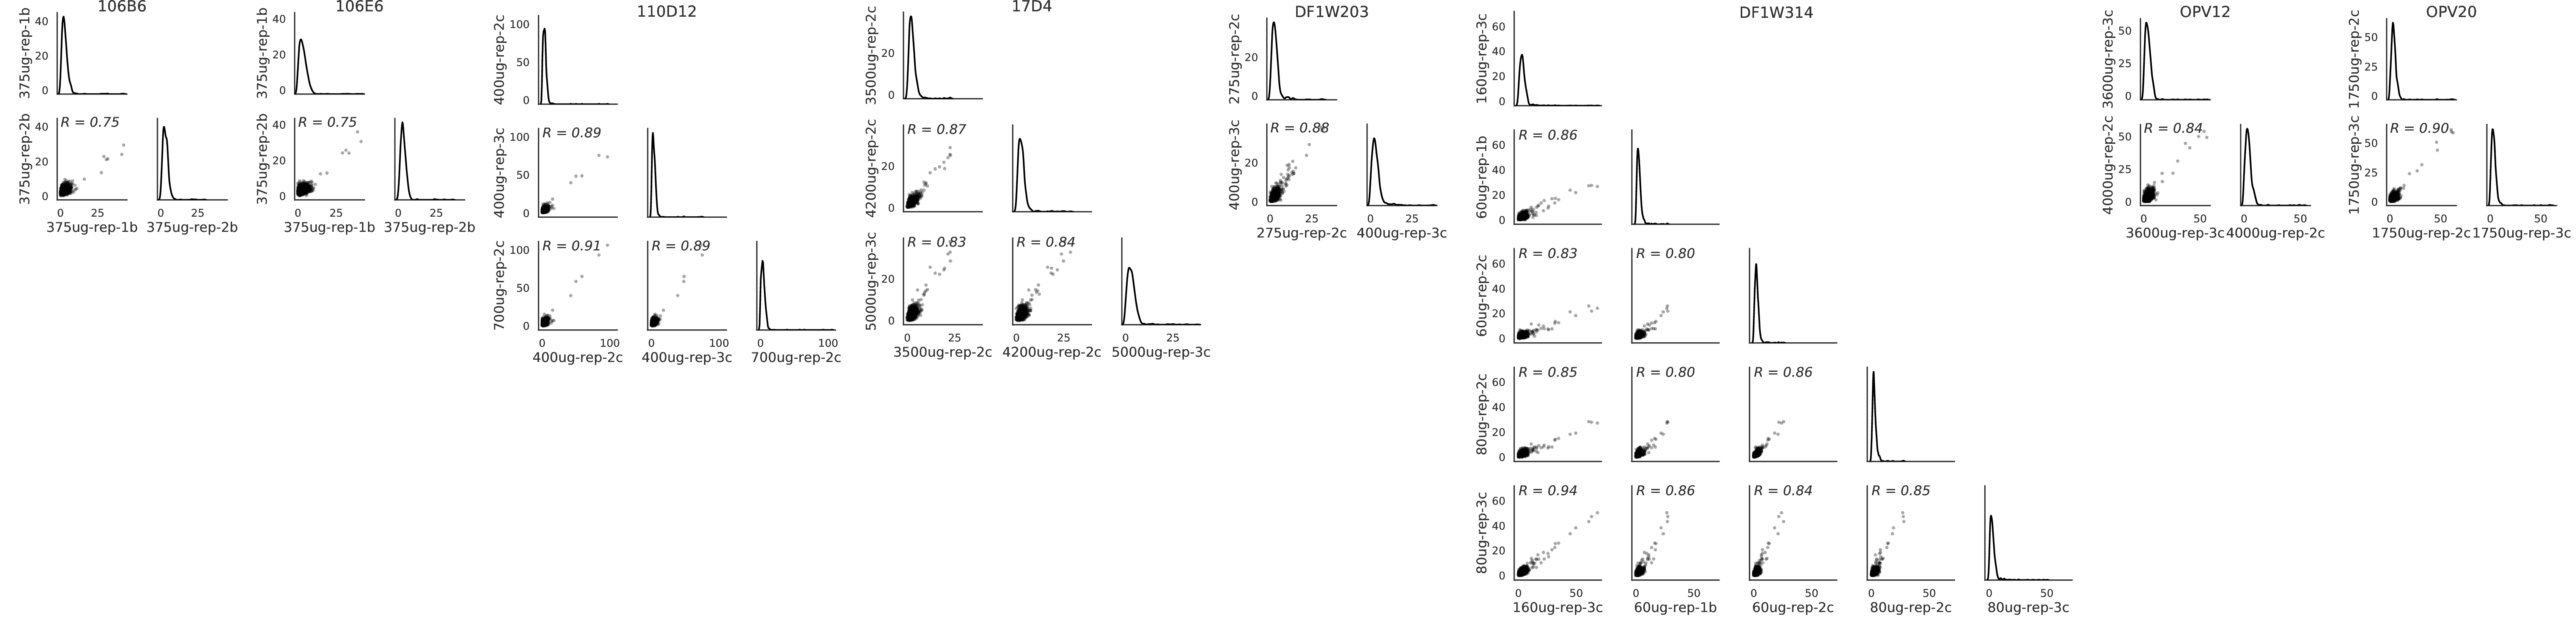


mutdiffsel correlations:


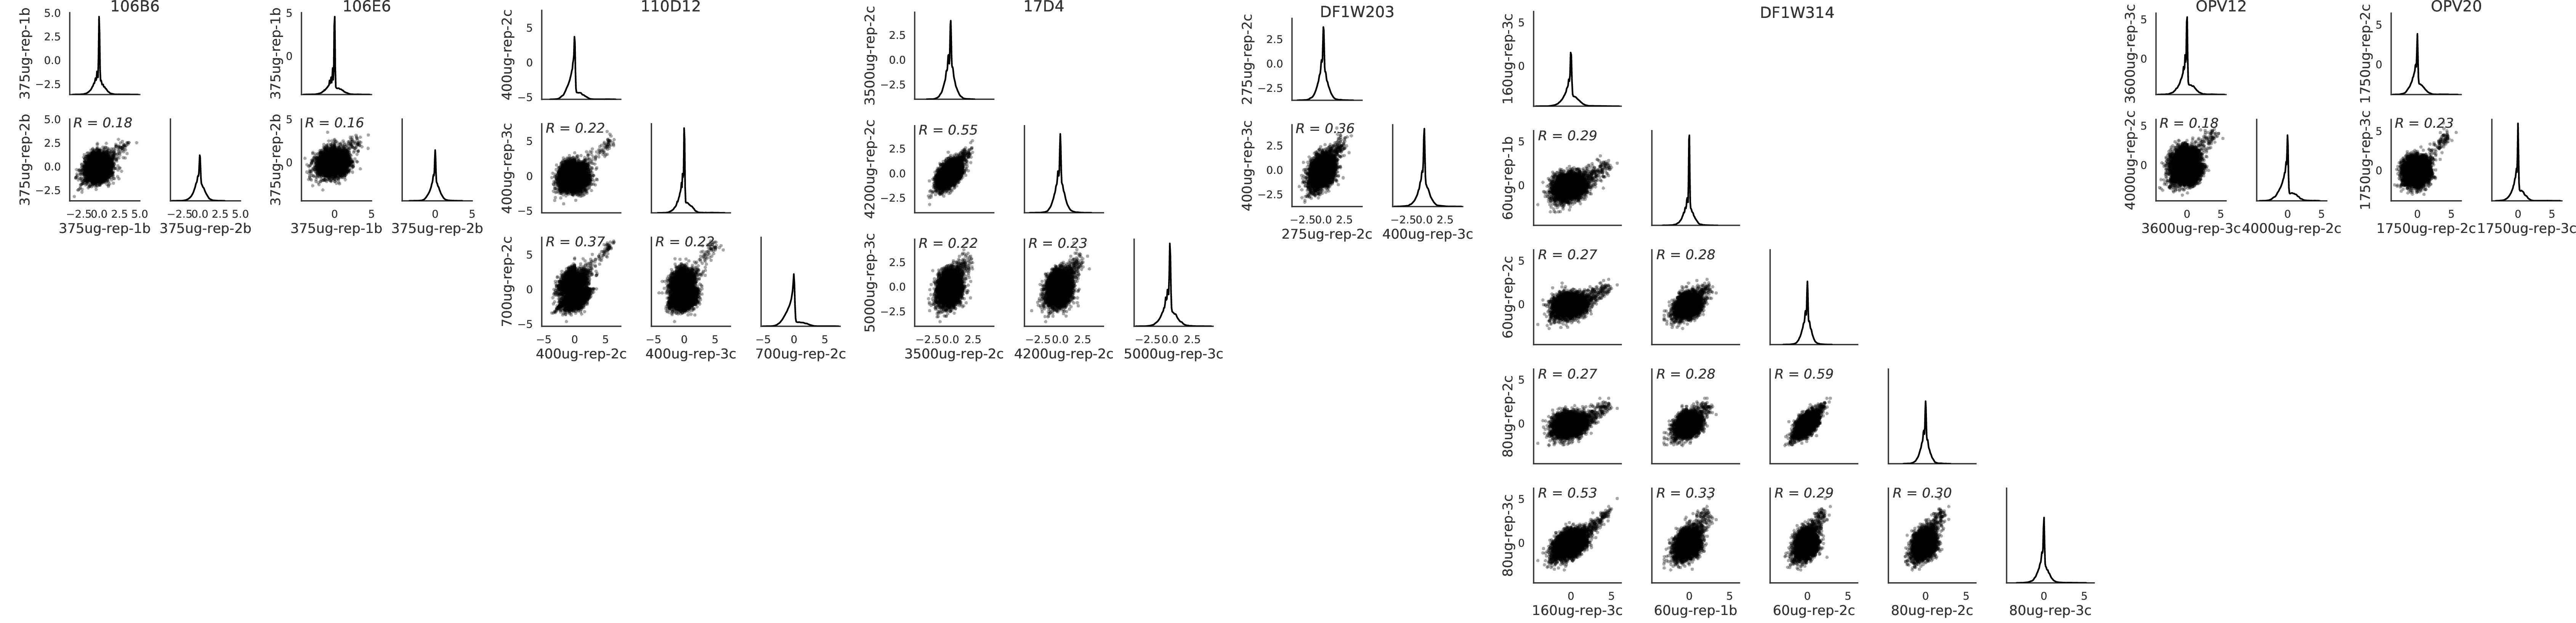

In [21]:
diffselprefix = os.path.join(diffsel_wtDNActrl_dir, 'summary_')

for seltype in ['positivesitediffsel', 'mutdiffsel']:
    print("\n{0} correlations:".format(seltype))
    plots = []
    for g in groups:
        plot = diffselprefix + g + '-' + seltype + 'corr.pdf'
        if os.path.isfile(plot):
            plots.append(plot)
        else:
            print("{0} does not exist.".format(plot))
    showPDF(plots, width=1800)

## Compute the fraction surviving 
Now we compute the [fraction surviving](https://jbloomlab.github.io/dms_tools2/fracsurvive.html).This caluclation takes into account the level of antibody selection, found in the input file below. We will use mutliple different controls to estimate the error rates to  correct fo, and put the output in its own subdirectory, named according to its control sample. 

This [csv file](/data/BG505_qPCR_master.csv) contains the fraction remaining infectivity for each antibody selected sample, as quatified using pol qPCR and computed based on a standard curve of infecting cells with dilutions of mutant virus (library and experiment specific), with dilutiuons ranging from 0.1 to .0001. 

We first create a batch file to use with [dms2_batch_fracsurvive](https://jbloomlab.github.io/dms_tools2/dms2_batch_fracsurvive.html). 
Note we make the **group** argument the antibody, the **name** argument the replicate, and assign the **sel**, **mock**, and **err** arguments based on the names used for the batch file when generating the counts files above with `dms2_batch_bcsubamp`.
By grouping replicates for the same antibody in the batch file, we tell [dms2_batch_fracsurvive](https://jbloomlab.github.io/dms_tools2/dms2_batch_fracsurvive.html) to analyze these together and take their mean and median.

In [22]:
fracsurvivedir = os.path.join(resultsdir, 'fracsurvive')
if not os.path.isdir(fracsurvivedir):
    os.mkdir(fracsurvivedir)
    
fracsurviveaboveavgdir = os.path.join(resultsdir, 'fracsurviveaboveavg')
if not os.path.isdir(fracsurviveaboveavgdir):
    os.mkdir(fracsurviveaboveavgdir) 

concavg_fracsurvivedir_wtDNActrl = os.path.join(fracsurvivedir, 'wtDNA_ctrl')
if not os.path.isdir(concavg_fracsurvivedir_wtDNActrl):
    os.mkdir(concavg_fracsurvivedir_wtDNActrl)  
concavg_fracsurviveaboveavgdir_wtDNActrl = os.path.join(fracsurviveaboveavgdir, 'wtDNA_ctrl')
if not os.path.isdir(concavg_fracsurviveaboveavgdir_wtDNActrl):
    os.mkdir(concavg_fracsurviveaboveavgdir_wtDNActrl)

In [23]:
concavg_fracsurvivebatch_wtDNActrl = diffselbatch_wtDNActrl.copy()
concavg_fracsurvivebatchfile_wtDNA = os.path.join(concavg_fracsurvivedir_wtDNActrl, 'batch.csv')
print("Here is the batch input that we write to the CSV file {0}:".format(concavg_fracsurvivebatchfile_wtDNA))
display(HTML(concavg_fracsurvivebatch_wtDNActrl.to_html(index=False)))
concavg_fracsurvivebatch_wtDNActrl.to_csv(concavg_fracsurvivebatchfile_wtDNA, index=False, encoding='utf-8')


for (arg_aboveavg, outdir) in [('', concavg_fracsurvivedir_wtDNActrl), ('--aboveavg yes', concavg_fracsurviveaboveavgdir_wtDNActrl)]:
    print("\nRunning dms2_batch_fracsurvive {0}and writing output to {1}".format(
            {'':'', '--aboveavg yes':'with `--aboveavg yes` '}[arg_aboveavg], outdir))
    log = !dms2_batch_fracsurvive \
            --summaryprefix summary \
            --batchfile {concavg_fracsurvivebatchfile_wtDNA} \
            --outdir {outdir} \
            --indir {renumberedcountsdir} \
            --use_existing {use_existing} \
            {arg_aboveavg} 
    print("Completed run.")

Here is the batch input that we write to the CSV file ./results/fracsurvive/wtDNA_ctrl/batch.csv:


group,name,sel,mock,err,mds_names,libfracsurvive
106B6,375ug-rep-1b,mut-virus-1b-106B6-375ug,mut-virus-1b,wt-DNA-1,106B6-375ug-375ug-rep-1b,0.159753
106B6,375ug-rep-2b,mut-virus-2b-106B6-375ug,mut-virus-2b,wt-DNA-2,106B6-375ug-375ug-rep-2b,0.028993
106E6,375ug-rep-2b,mut-virus-2b-106E6-375ug,mut-virus-2b,wt-DNA-2,106E6-375ug-375ug-rep-2b,0.071179
106E6,375ug-rep-1b,mut-virus-1b-106E6-375ug,mut-virus-1b,wt-DNA-1,106E6-375ug-375ug-rep-1b,0.117901
110D12,700ug-rep-2c,mut-virus-2c-110D12-700ug,mut-virus-2c,wt-DNA-2,110D12-700ug-700ug-rep-2c,0.006387
110D12,400ug-rep-2c,mut-virus-2c-110D12-400ug,mut-virus-2c,wt-DNA-2,110D12-400ug-400ug-rep-2c,0.008322
110D12,400ug-rep-3c,mut-virus-3c-110D12-400ug,mut-virus-3c,wt-DNA-3,110D12-400ug-400ug-rep-3c,0.006987
17D4,4200ug-rep-2c,mut-virus-2c-17D4-4200ug,mut-virus-2c,wt-DNA-2,17D4-4200ug-4200ug-rep-2c,0.108594
17D4,5000ug-rep-3c,mut-virus-3c-17D4-5000ug,mut-virus-3c,wt-DNA-3,17D4-5000ug-5000ug-rep-3c,0.051157
17D4,3500ug-rep-2c,mut-virus-2c-17D4-3500ug,mut-virus-2c,wt-DNA-2,17D4-3500ug-3500ug-rep-2c,0.176506



Running dms2_batch_fracsurvive and writing output to ./results/fracsurvive/wtDNA_ctrl
Completed run.

Running dms2_batch_fracsurvive with `--aboveavg yes` and writing output to ./results/fracsurviveaboveavg/wtDNA_ctrl
Completed run.


In [43]:
for antibody in groups:
    mutdiffsel = os.path.join(concavg_fracsurviveaboveavgdir_wtDNActrl, 'summary_{0}-medianmutfracsurvive.csv'.format(antibody))
    logoplot = os.path.join(concavg_fracsurviveaboveavgdir_wtDNActrl, '{0}-median_fracsurvive.pdf'.format(antibody))
        #scale bar unit is maximum effect
    mutdiffseldf = pd.read_csv(mutdiffsel)
    scaleunit = '{0:.1g}'.format(mutdiffseldf['mutfracsurvive'].max())
    scalelabel = '"fraction surviving above avg = {0}"'.format(scaleunit)
    logoname = '{0}-median'.format(antibody)
    print("Creating logo plot for {0} from {1}".format(antibody, mutdiffsel))
    log = !dms2_logoplot \
            --fracsurvive {mutdiffsel} \
            --name {logoname} \
            --outdir {concavg_fracsurviveaboveavgdir_wtDNActrl} \
            --sepline no \
            --nperline 84 \
            --overlay1 {mutdiffsel} wildtype wildtype \
            --scalebar {scaleunit} {scalelabel} \
            --underlay yes \
            --use_existing {use_existing}
    #showPDF(logoplot)
    
    mutdiffsel = os.path.join(concavg_fracsurvivedir_wtDNActrl, 'summary_{0}-medianmutfracsurvive.csv'.format(antibody))
    logoplot = os.path.join(concavg_fracsurvivedir_wtDNActrl, '{0}-median_fracsurvive.pdf'.format(antibody))
        #scale bar unit is maximum effect
    mutdiffseldf = pd.read_csv(mutdiffsel)
    scaleunit = '{0:.1g}'.format(mutdiffseldf['mutfracsurvive'].max())
    scalelabel = '"fraction surviving = {0}"'.format(scaleunit)
    logoname = '{0}-median'.format(antibody)
    print("Creating logo plot for {0} from {1}".format(antibody, mutdiffsel))
    log = !dms2_logoplot \
            --fracsurvive {mutdiffsel} \
            --name {logoname} \
            --outdir {concavg_fracsurvivedir_wtDNActrl} \
            --sepline no \
            --nperline 84 \
            --overlay1 {mutdiffsel} wildtype wildtype \
            --scalebar {scaleunit} {scalelabel} \
            --underlay yes \
            --use_existing {use_existing}
    #showPDF(logoplot)

Creating logo plot for 106B6 from ./results/fracsurviveaboveavg/wtDNA_ctrl/summary_106B6-medianmutfracsurvive.csv
Creating logo plot for 106B6 from ./results/fracsurvive/wtDNA_ctrl/summary_106B6-medianmutfracsurvive.csv
Creating logo plot for 106E6 from ./results/fracsurviveaboveavg/wtDNA_ctrl/summary_106E6-medianmutfracsurvive.csv
Creating logo plot for 106E6 from ./results/fracsurvive/wtDNA_ctrl/summary_106E6-medianmutfracsurvive.csv
Creating logo plot for 110D12 from ./results/fracsurviveaboveavg/wtDNA_ctrl/summary_110D12-medianmutfracsurvive.csv
Creating logo plot for 110D12 from ./results/fracsurvive/wtDNA_ctrl/summary_110D12-medianmutfracsurvive.csv
Creating logo plot for 17D4 from ./results/fracsurviveaboveavg/wtDNA_ctrl/summary_17D4-medianmutfracsurvive.csv
Creating logo plot for 17D4 from ./results/fracsurvive/wtDNA_ctrl/summary_17D4-medianmutfracsurvive.csv
Creating logo plot for DF1W203 from ./results/fracsurviveaboveavg/wtDNA_ctrl/summary_DF1W203-medianmutfracsurvive.csv
Cr

In [24]:
for antibody in groups:

    mutdiffsel = os.path.join(diffsel_wtDNActrl_dir, 'summary_{0}-medianmutdiffsel.csv'.format(antibody))
    # now create the logo plot with the overlay
    #scale bar unit is maximum effect
    mutdiffseldf = pd.read_csv(mutdiffsel)
    scaleunit = '10'
    #scaleunit = '{0:.1g}'.format(mutdiffseldf['mutdiffsel'].max())
    scalelabel = '"differential selection = {0}"'.format(scaleunit)
    logoplot = os.path.join(diffsel_wtDNActrl_dir, '{0}_diffsel.pdf'.format(antibody))
    print(logoplot)
    print("\nCreating logo plot for {0} from {1}".format(antibody, mutdiffsel))
    log = !dms2_logoplot \
            --diffsel {mutdiffsel} \
            --name {antibody} \
            --outdir {diffsel_wtDNActrl_dir} \
            --restrictdiffsel positive \
            --sepline no \
            --nperline 84 \
            --overlay1 {mutdiffsel} wildtype wildtype \
            --scalebar {scaleunit} {scalelabel} \
            --underlay yes \
            --use_existing {use_existing}
    #showPDF(logoplot)

./results/diffsel/wtDNA_ctrl/106B6_diffsel.pdf

Creating logo plot for 106B6 from ./results/diffsel/wtDNA_ctrl/summary_106B6-medianmutdiffsel.csv
./results/diffsel/wtDNA_ctrl/106E6_diffsel.pdf

Creating logo plot for 106E6 from ./results/diffsel/wtDNA_ctrl/summary_106E6-medianmutdiffsel.csv
./results/diffsel/wtDNA_ctrl/110D12_diffsel.pdf

Creating logo plot for 110D12 from ./results/diffsel/wtDNA_ctrl/summary_110D12-medianmutdiffsel.csv
./results/diffsel/wtDNA_ctrl/17D4_diffsel.pdf

Creating logo plot for 17D4 from ./results/diffsel/wtDNA_ctrl/summary_17D4-medianmutdiffsel.csv
./results/diffsel/wtDNA_ctrl/DF1W203_diffsel.pdf

Creating logo plot for DF1W203 from ./results/diffsel/wtDNA_ctrl/summary_DF1W203-medianmutdiffsel.csv
./results/diffsel/wtDNA_ctrl/DF1W314_diffsel.pdf

Creating logo plot for DF1W314 from ./results/diffsel/wtDNA_ctrl/summary_DF1W314-medianmutdiffsel.csv
./results/diffsel/wtDNA_ctrl/OPV12_diffsel.pdf

Creating logo plot for OPV12 from ./results/diffsel/wtDNA_ctrl/s

`fracsruviveaboveavg` analyses appear _very_ similar to `diffsel`, though cleaner. However, some `mutfracsuvive` values >> 1, thus suggesting qPCR was inaccruate. I will use the `diffsel` values in the paper, which also matches [Dingens et al. Plos Pathogens 2018](https://journals.plos.org/plospathogens/article?id=10.1371/journal.ppat.1007159).

### Visualize the differential selection
 

In [2]:
figuredir = "./results/diffsel/Figures/"
if not os.path.isdir(figuredir):
    os.mkdir(figuredir)

In [3]:
import warnings
warnings.filterwarnings('ignore')

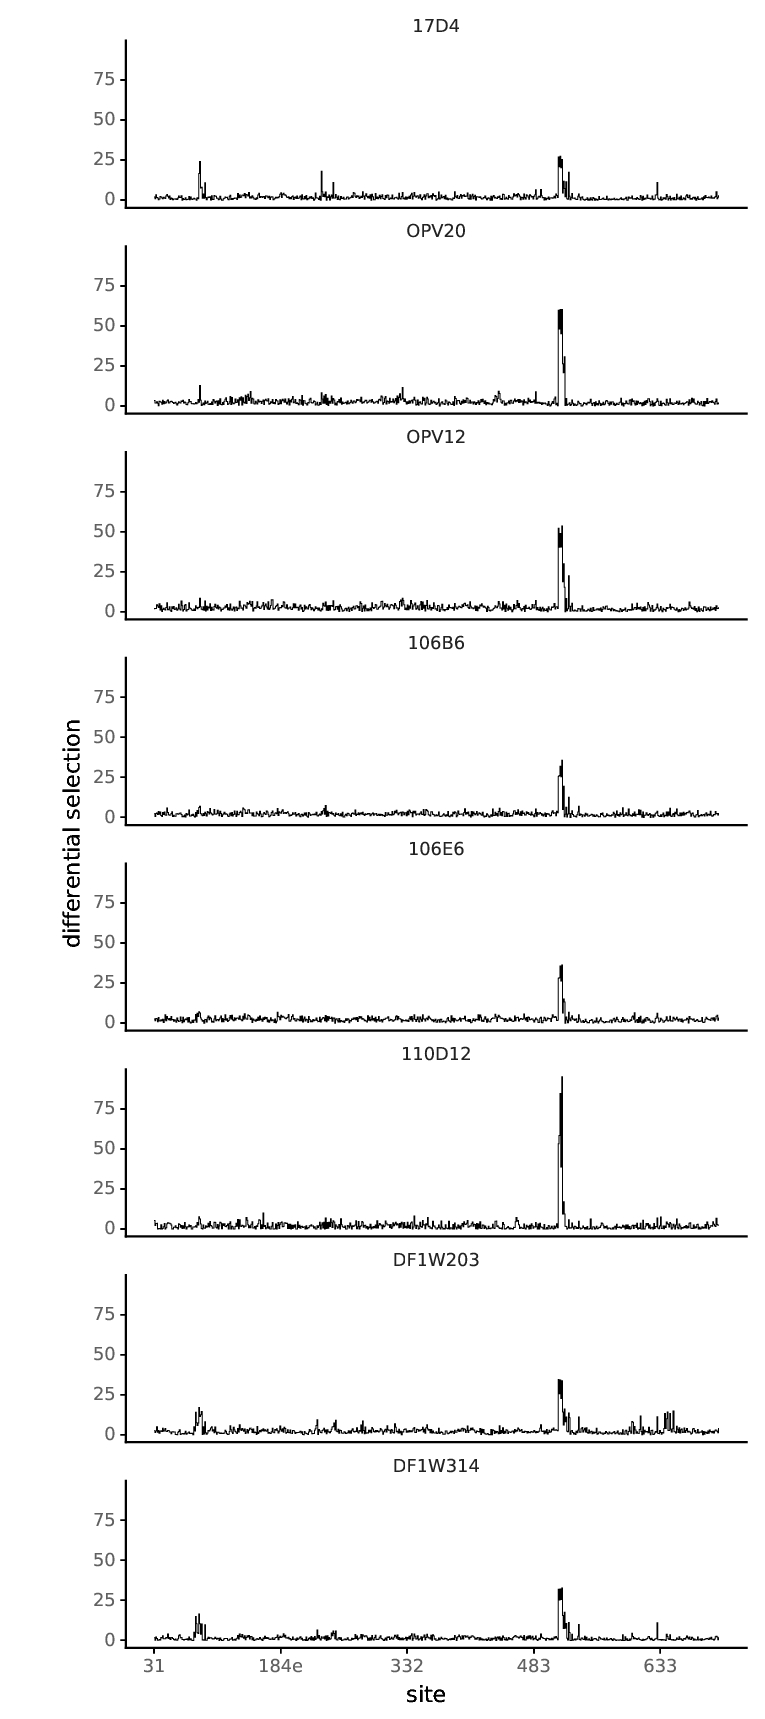

In [8]:
#will revisit this. 
names = ["17D4", "OPV20", "OPV12", "106B6", "106E6", "110D12", "DF1W203", "DF1W314"]
#names = ["VRC34.01", "vFP16.02", "vFP20.01"]
diffselfiles = ["./results/diffsel/wtDNA_ctrl/summary_17D4-mediansitediffsel.csv", 
                "./results/diffsel/wtDNA_ctrl/summary_OPV20-mediansitediffsel.csv", 
                "./results/diffsel/wtDNA_ctrl/summary_OPV12-mediansitediffsel.csv",
                "./results/diffsel/wtDNA_ctrl/summary_106B6-mediansitediffsel.csv", 
                "./results/diffsel/wtDNA_ctrl/summary_106E6-mediansitediffsel.csv",
                "./results/diffsel/wtDNA_ctrl/summary_110D12-mediansitediffsel.csv", 
                "./results/diffsel/wtDNA_ctrl/summary_DF1W203-mediansitediffsel.csv", 
                "./results/diffsel/wtDNA_ctrl/summary_DF1W314-mediansitediffsel.csv"]
plotfile = './results/diffsel/Figures/Positive_diffsel_fig.pdf'
dms_tools2.plot.plotSiteDiffSel(names, diffselfiles, plotfile, "positive", maxcol=1, white_bg=True)
showPDF(plotfile)

In [ ]:
#now, plot each on their own axis, with an underlay

In [32]:
import re
import os
import math
import natsort
#import pandas
import numpy
import scipy.stats
import matplotlib
matplotlib.use('pdf')
import matplotlib.pyplot as plt
from matplotlib import rc
from plotnine import *
# set ggplot theme
theme_set(theme_bw(base_size=12)) 

import seaborn


from dms_tools2 import CODONS, AAS, AAS_WITHSTOP
import dms_tools2.utils
COLOR_BLIND_PALETTE = ["#000000", "#E69F00", "#56B4E9", "#009E73",
                       "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

def plotSiteDiffSel_YLimDiff(names, diffselfiles, plotfile, 
        diffseltype, y_lim=None, highlighted_sites =None, underlay_1 = None, point = None, maxcol=2, white_bg=False):
    """Plot site diffsel or fracsurvive along sequence.
    Despite the function name, this function can be used to
    plot either differential selection or fraction surviving.
    Args:
        `names` (list or series)
            Names of samples for which we plot statistics.
        `diffselfiles` (list or series)
            ``*sitediffsel.csv`` files from ``dms2_diffsel`` or
            ``*sitefracsurvive.csv`` files from ``dms2_fracsurvive``.
        `plotfile` (str)
            Name of created PDF plot file.
        `diffseltype` (str)
            Type of diffsel or fracsurvive to plot:
                - `positive`: positive sitediffsel
                - `total`: positive and negative sitediffsel
                - `max`: maximum mutdiffsel
                - `minmax`: minimum and maximum mutdiffsel
                - `avgfracsurvive`: total site fracsurvive
                - `maxfracsurvive`: max mutfracsurvive at site
        `maxcol` (int)
            Number of columns in faceted plot.
        `white_bg` (bool)
            Plots will have a white background with limited other formatting.
            
        DOCUMENT CHANGES
    """
    assert len(names) == len(diffselfiles) == len(set(names)) > 0
    assert os.path.splitext(plotfile)[1].lower() == '.pdf'

    diffsels = [pd.read_csv(f).assign(name=name) for (name, f) 
            in zip(names, diffselfiles)]
    assert all([set(diffsels[0]['site']) == set(df['site']) for df in 
            diffsels]), "diffselfiles not all for same sites"
    diffsel = pd.concat(diffsels, ignore_index=True)

    ylabel = 'differential selection'
    if diffseltype == 'positive':
        rename = {'positive_diffsel':'above'}
    elif diffseltype == 'total':
        rename = {'positive_diffsel':'above',
                  'negative_diffsel':'below'}
    elif diffseltype == 'max':
        rename = {'max_diffsel':'above'}
    elif diffseltype == 'minmax':
        rename = {'max_diffsel':'above',
                  'min_diffsel':'below'}
    elif diffseltype in ['avgfracsurvive', 'maxfracsurvive']:
        ylabel = 'fraction surviving'
        rename = {diffseltype:'above'}
    else:
        raise ValueError("invalid diffseltype {0}".format(diffseltype))
    diffsel = (diffsel.rename(columns=rename)
                      .melt(id_vars=['site', 'name'], 
                            value_vars=list(rename.values()),
                            value_name='diffsel',
                            var_name='direction')
                      )


    # natural sort by site: https://stackoverflow.com/a/29582718
    diffsel = diffsel.reindex(index=natsort.order_by_index(
            diffsel.index, natsort.index_natsorted(diffsel.site,
            signed=True)))
    # now some manipulations to make site str while siteindex is int
    diffsel['site'] = diffsel['site'].apply(str)
    diffsel['siteindex'] = pd.Categorical(diffsel['site'],
            diffsel['site'].unique()).codes
    
    ncol = min(maxcol, len(names))
    nrow = math.ceil(len(names) / float(ncol))
    y_lim_min = y_lim - (float(y_lim/30))

    # make name a category to preserve order
    diffsel['name'] = diffsel['name'].astype('category', 
            categories=names)
    
    (xbreaks, xlabels) = dms_tools2.plot.breaksAndLabels(diffsel['siteindex'].unique(), 
            diffsel['site'].unique(), n=6)
    
    diffsel['highlight'] = diffsel['site'].isin(highlighted_sites) 
    diffsel['highlight'] =np.where(diffsel['highlight']==True , -0.0092, -1)#-0.0092, -1)#-1)
    #diffsel['underlay_1'] = 0.16
    diffsel['underlay_1'] = diffsel['site'].isin(underlay_1)
    ymin = float(y_lim) *(float(.005/.15))*float(-1)
    diffsel['underlay_1'] =np.where(diffsel['underlay_1']==True , ymin, -5)
    diffsel['point'] = diffsel['site'].isin(point)
    diffsel['point'] =np.where(diffsel['point']==True , -0.0069, -1)
    
    

    if white_bg:
        p = (ggplot(diffsel, aes(x='siteindex', y='diffsel',
                    color='direction', fill='direction'))
             
             + geom_point(aes(y='underlay_1'), color=None, fill="#FF0000", shape="|", size=3, show_legend=False) #light blue - #0072b2 old color: "#440154ff"
             + geom_step(size=0.3)
             + scale_y_continuous(limits=(ymin, y_lim))#-0.0092, y_lim))
             + xlab('site')
             + ylab(ylabel)
             + scale_x_continuous(breaks=xbreaks, labels=xlabels)
             + scale_color_manual(COLOR_BLIND_PALETTE)
             + scale_fill_manual(COLOR_BLIND_PALETTE)
             + guides(color=False)
             + theme(#panel_background=element_rect(fill='white'),
                     axis_line_x=element_line(color='black'),
                     axis_line_y=element_line(color='black'),
                     axis_title_x=element_blank(),
                     axis_title_y=element_blank(),
                     panel_grid=element_blank(),
                     panel_border=element_blank(),
                     strip_background=element_blank()
                     )
            )
    else:
        p = (ggplot(diffsel, aes(x='siteindex', y='diffsel', color='direction'))
             + geom_step(size=0.4)
             + xlab('site')
             + scale_y_continuous(limits=(0, y_lim))
             + ylab(ylabel)
             + scale_x_continuous(breaks=xbreaks, labels=xlabels)
             + scale_color_manual(COLOR_BLIND_PALETTE)
             + guides(color=False)
             )
    if not ((len(names) == 1) and ((not names[0]) or names[0].isspace())):
        p += facet_wrap('~name', ncol=ncol)
    p += theme(figure_size=(4.6 * (0.3 + ncol), 1.9 * (0.2 + nrow)))
    p.save(plotfile, verbose=False, transparent=True)
plt.close()

In [82]:
sitediffsel_dict = {}
names = ["17D4", "OPV20", "OPV12", "106B6", "106E6", "110D12", "DF1W203", "DF1W314"]
for ab in names:
    sitediffsel_dict[ab] = "./results/diffsel/wtDNA_ctrl/summary_{0}-mediansitediffsel.csv".format(ab)
#print(sitediffsel_dict)

In [40]:
keysites_all = list(range(80, 92)) + list(range(227, 244)) + list(range(512, 525)) + list(range(536, 537)) + list(range(629, 630))

# Env sites numbers are strings because some have trailing letters (e.g., 100A)
keysites_all = list(map(str, keysites_all))


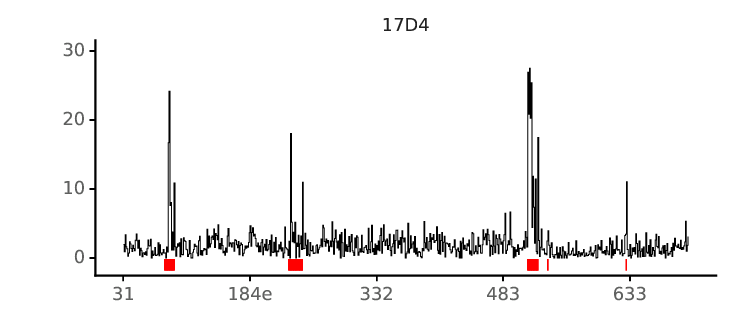

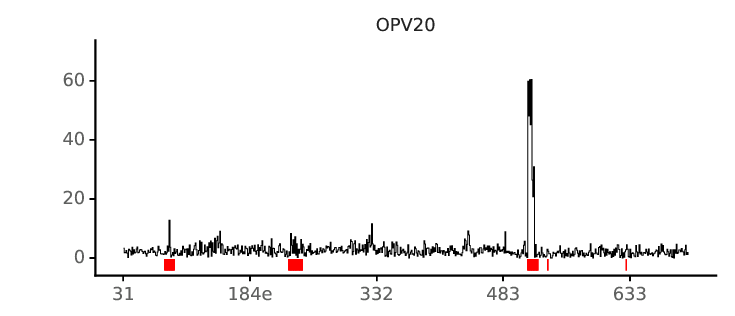

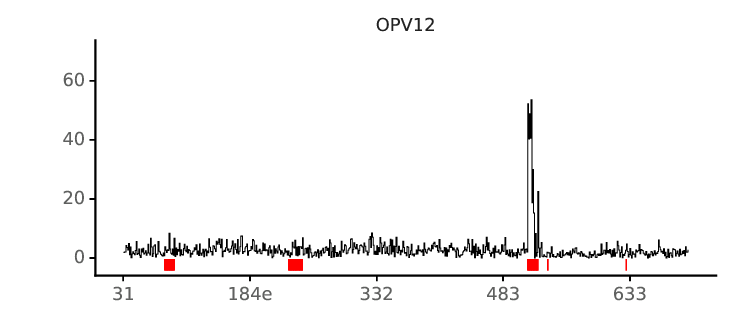

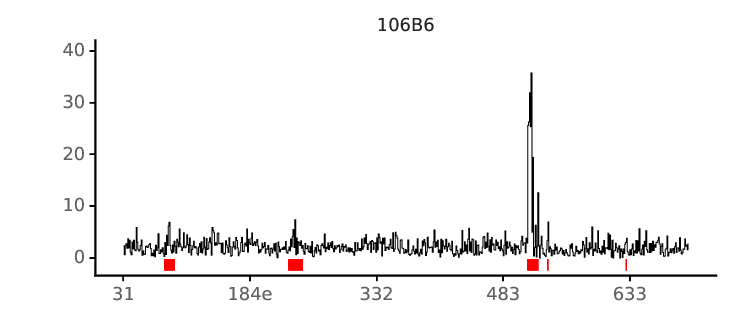

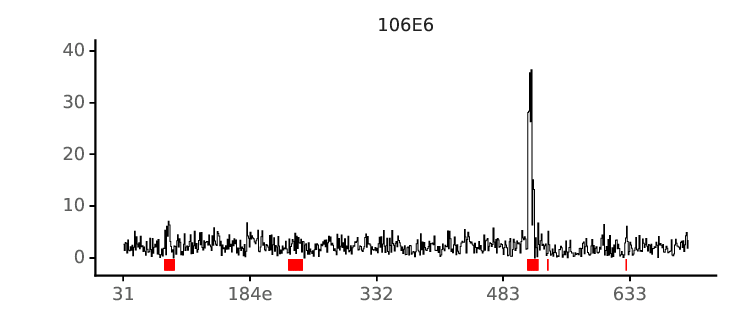

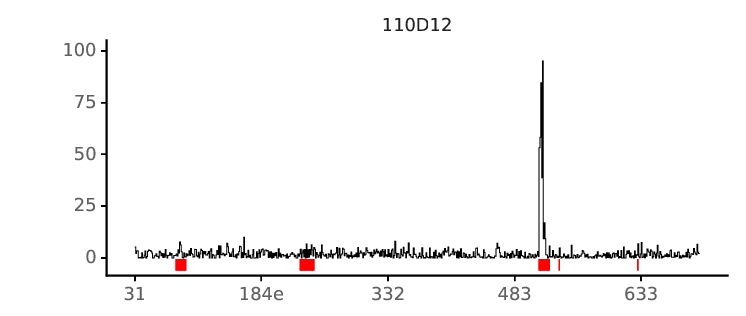

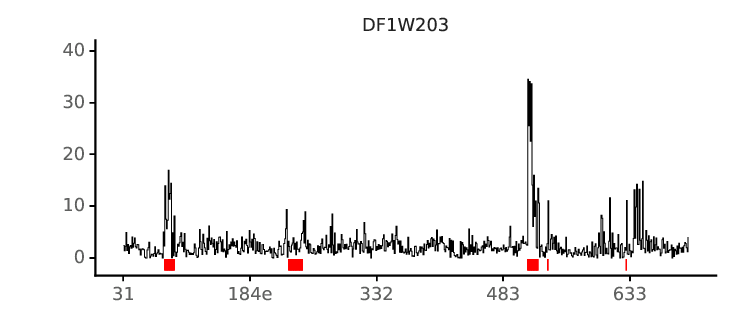

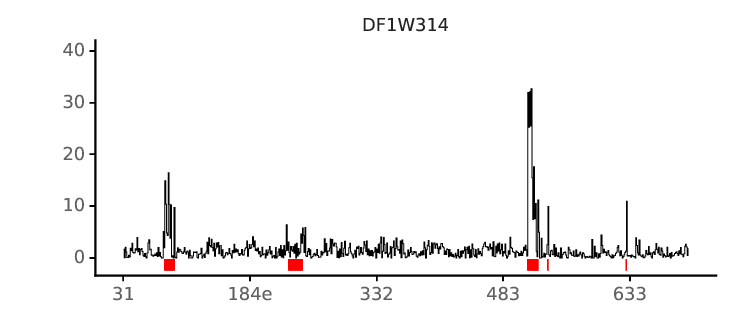

In [50]:
ylimdict = {}
ylimdict['17D4'] = 30
ylimdict['OPV20'] = 70
ylimdict['OPV12'] = 70
ylimdict['106B6'] = 40
ylimdict['106E6'] = 40
ylimdict['110D12'] = 100
ylimdict['DF1W203'] = 40
ylimdict['DF1W314'] = 40

plots = []
diffseltype = "avgfracsurvive"
for antibody in names:
    #print(antibody)
    plotfile = "./results/diffsel/Figures/{0}-median-positivesitediffsel-annotated.pdf".format(antibody)
    epitope_sites = keysites_all
    significant_sites = []
    highlighted_sites = []
    names = [antibody]
    ylimit = ylimdict[antibody]
    diffselfiles = [sitediffsel_dict[antibody]]
    plotSiteDiffSel_YLimDiff(names, diffselfiles, plotfile, "positive", maxcol=1, underlay_1=epitope_sites, point=significant_sites, highlighted_sites=highlighted_sites, y_lim=ylimit, white_bg=True)
    
    plots.append(plotfile)
    showPDF(plotfile)
#showPDF(plots)

## Make logoplots of key sites 
Now, we will zoom in on the escape profile in regions of interest. 

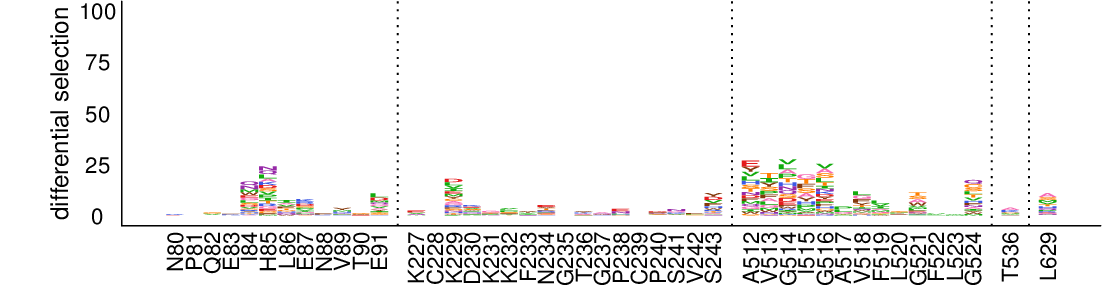

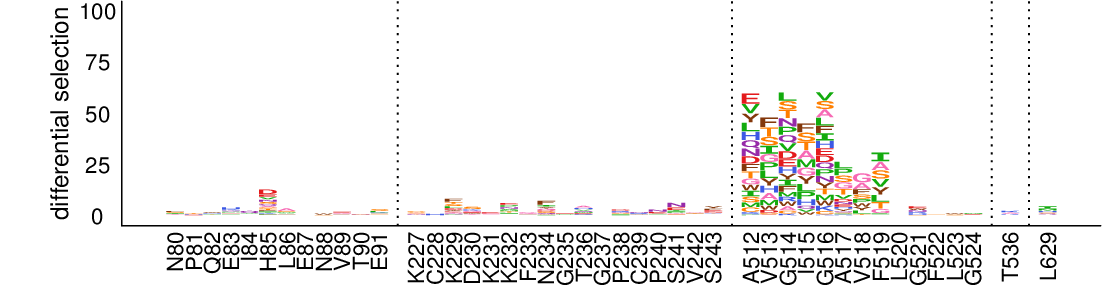

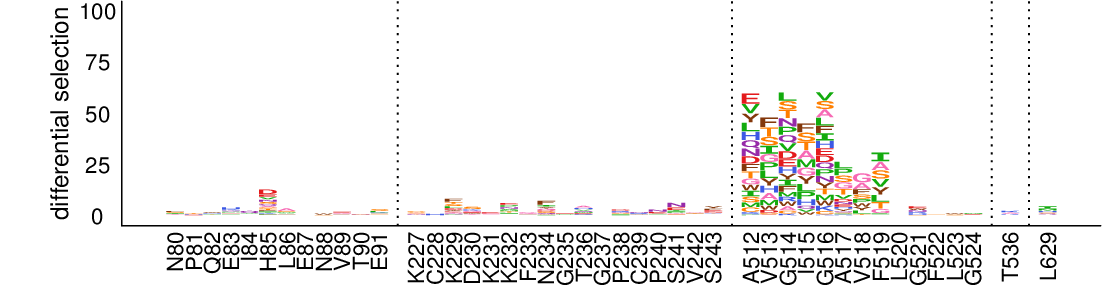

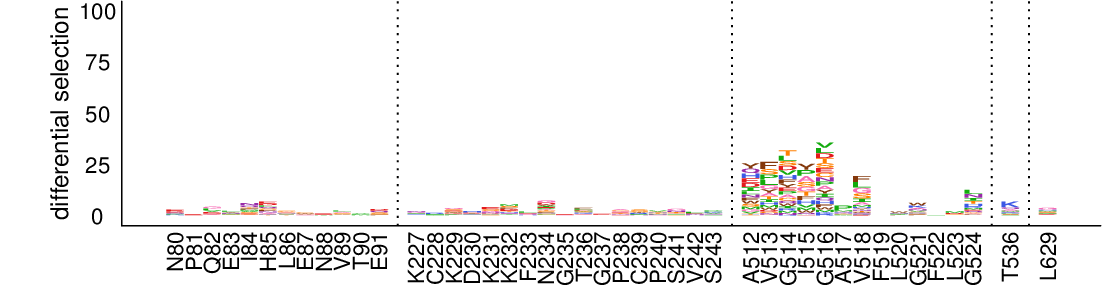

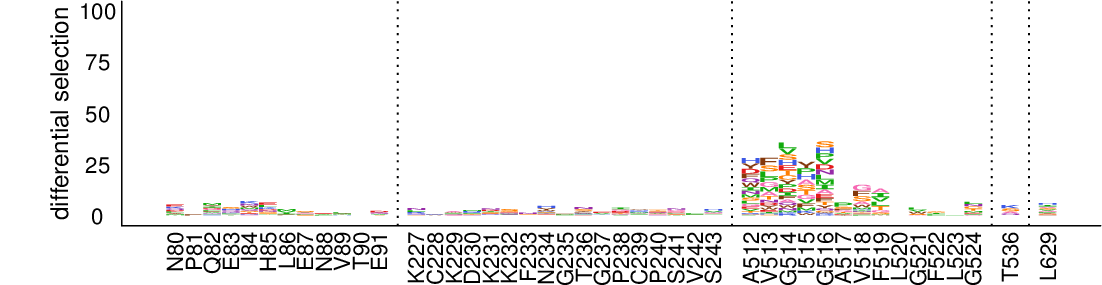

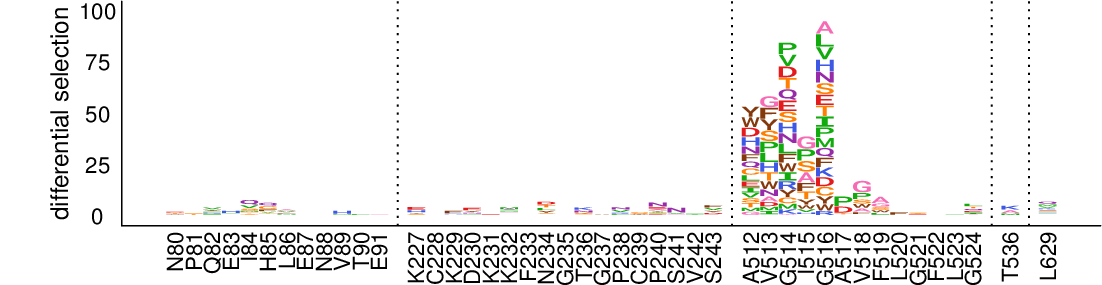

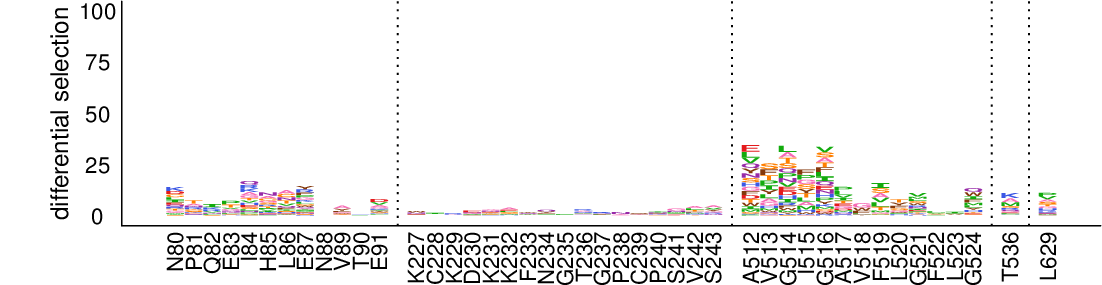

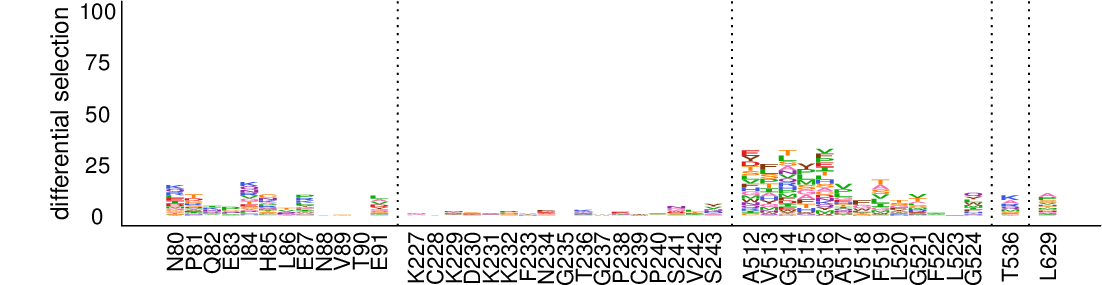

In [42]:
#import rpy2.robjects
import natsort
#diffsel_wtDNActrl_dir
names = ["17D4", "OPV20", "OPV12", "106B6", "106E6", "110D12", "DF1W203", "DF1W314"]
#names = ["VRC34.01", "vFP16.02", "vFP20.01"]
diffselfiles = ["./results/diffsel/wtDNA_ctrl/summary_17D4-medianmutdiffsel.csv", 
                "./results/diffsel/wtDNA_ctrl/summary_OPV20-medianmutdiffsel.csv", 
                "./results/diffsel/wtDNA_ctrl/summary_OPV20-medianmutdiffsel.csv",
                "./results/diffsel/wtDNA_ctrl/summary_106B6-medianmutdiffsel.csv", 
                "./results/diffsel/wtDNA_ctrl/summary_106E6-medianmutdiffsel.csv", 
                "./results/diffsel/wtDNA_ctrl/summary_110D12-medianmutdiffsel.csv",
                "./results/diffsel/wtDNA_ctrl/summary_DF1W203-medianmutdiffsel.csv", 
                "./results/diffsel/wtDNA_ctrl/summary_DF1W314-medianmutdiffsel.csv"
               ]

mutdiffsels = [] #list of csv files
for mutdiffsel, name in zip(diffselfiles, names): 
    pandadf = pd.read_csv(mutdiffsel)
    # read data frame from tidy CSV format to wide form
    df = dms_tools2.diffsel.tidyToWide(pandadf, valuecol='mutdiffsel')
    
    # only show positive values of mutdiffsel
    df[dms_tools2.AAS] = df[dms_tools2.AAS].clip(lower=0)
    
    #sort sites by 
    df = df.reindex(index=natsort.order_by_index(df.index,natsort.index_natsorted(df.site)))
    
    # add a column indicating what we should show
    df['show'] = df['site'].isin(keysites_all)
    
    # want to indicate wildtype along with site number, e.g, A512
    df['site'] = df['wildtype'] + df['site']
    # name of file to plot
    zoomlogoplot = os.path.join(diffsel_wtDNActrl_dir, '{0}_zoomed_diffsel.pdf'.format(name))
    # plot and show
    dms_tools2.rplot.siteSubsetGGSeqLogo(
            logodata=df,
            chars=dms_tools2.AAS,
            plotfile=zoomlogoplot,
            width=8,
            height=2.5,
            yname='differential selection',
            ylimits=(0,100),
            )
    showPDF(zoomlogoplot)

In [56]:
mutdiffsel_dict = {}
for ab in sitediffsel_dict.keys():
    mutdiffsel_dict[ab] = "./results/diffsel/wtDNA_ctrl/summary_{0}-medianmutdiffsel.csv".format(ab)
#print(mutdiffsel_dict)

In [70]:
import natsort
def EpitopeDiffselLogoplot(mutfracsurvivefile, keysites, outfile, max_diffsel):
    pandadf = pd.read_csv(mutfracsurvivefile)
    df = dms_tools2.diffsel.tidyToWide(pandadf, valuecol='mutdiffsel')

    #sort sites 
    df = df.reindex(index=natsort.order_by_index(df.index,natsort.index_natsorted(df.site)))
    df['show'] = df['site'].isin(keysites)
    df['site'] = df['wildtype'] + df['site']
    width = len(keysites) / 2.5
    dms_tools2.rplot.siteSubsetGGSeqLogo(
        logodata=df,
        chars=dms_tools2.AAS,
        plotfile=outfile,
        width= width,
        height=3.5,
        yname='differential selection',
        ylimits=(0,max_diffsel),
    )

Here is the differential selection for 17D4 at sites of interest


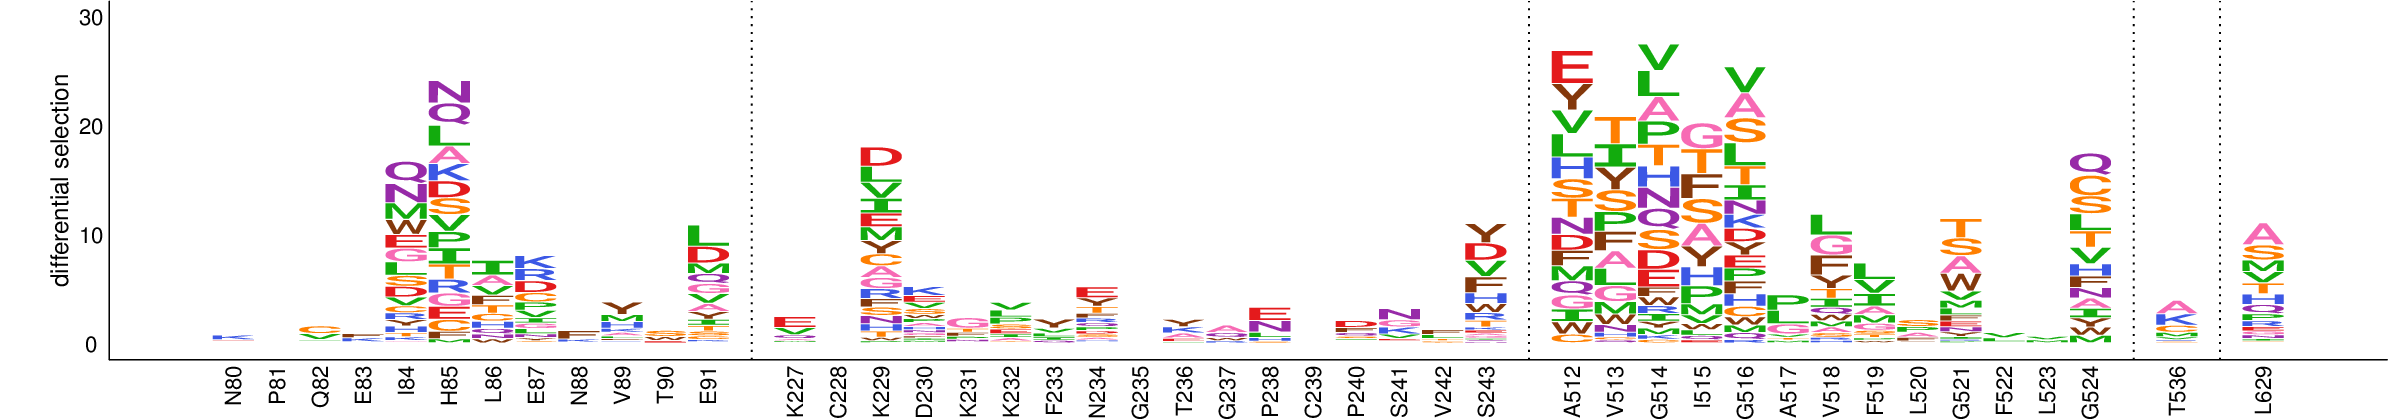

Here is the differential selection for OPV20 at sites of interest


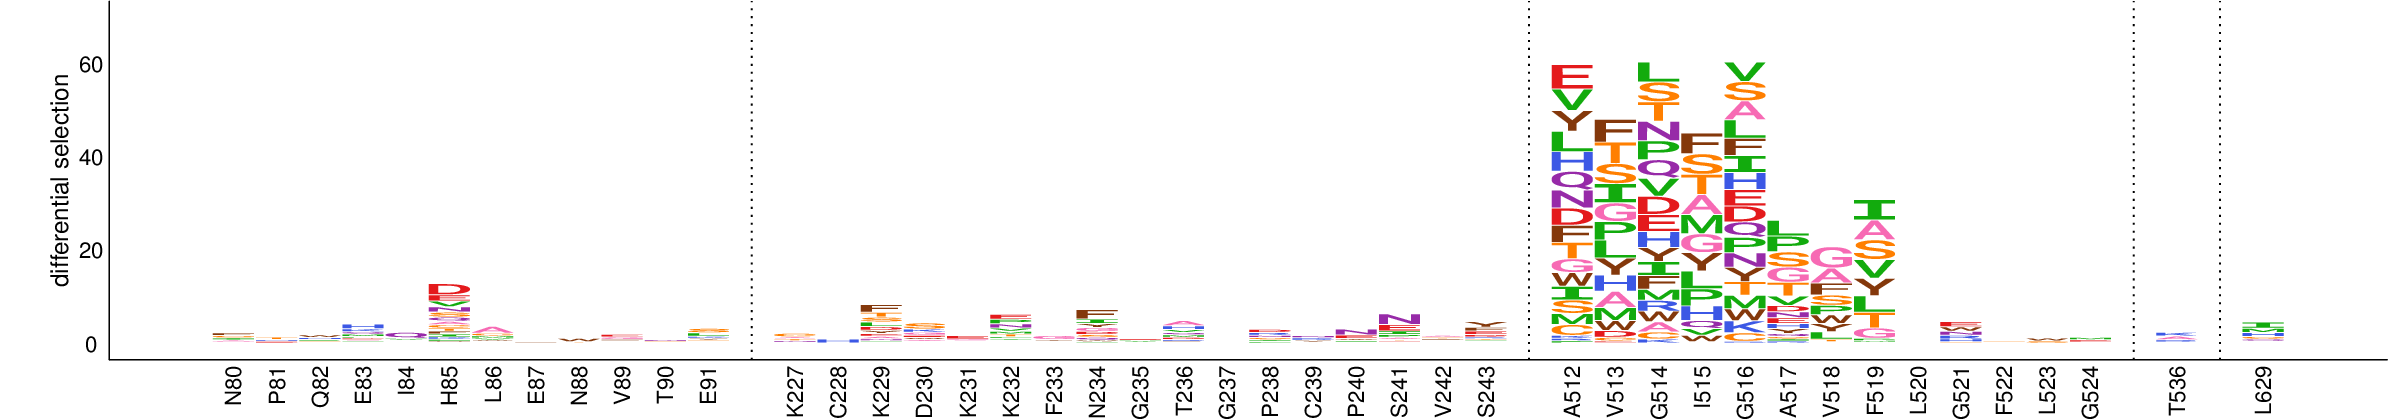

Here is the differential selection for OPV12 at sites of interest


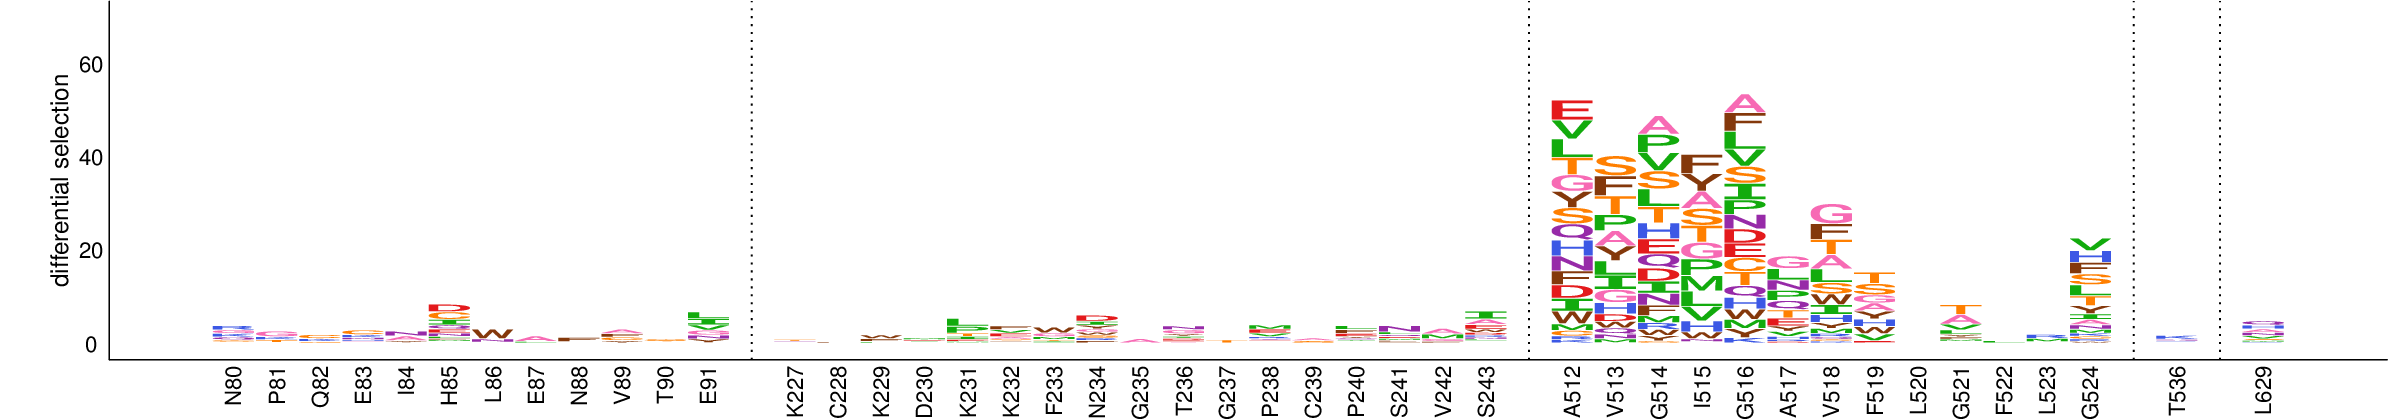

Here is the differential selection for 106B6 at sites of interest


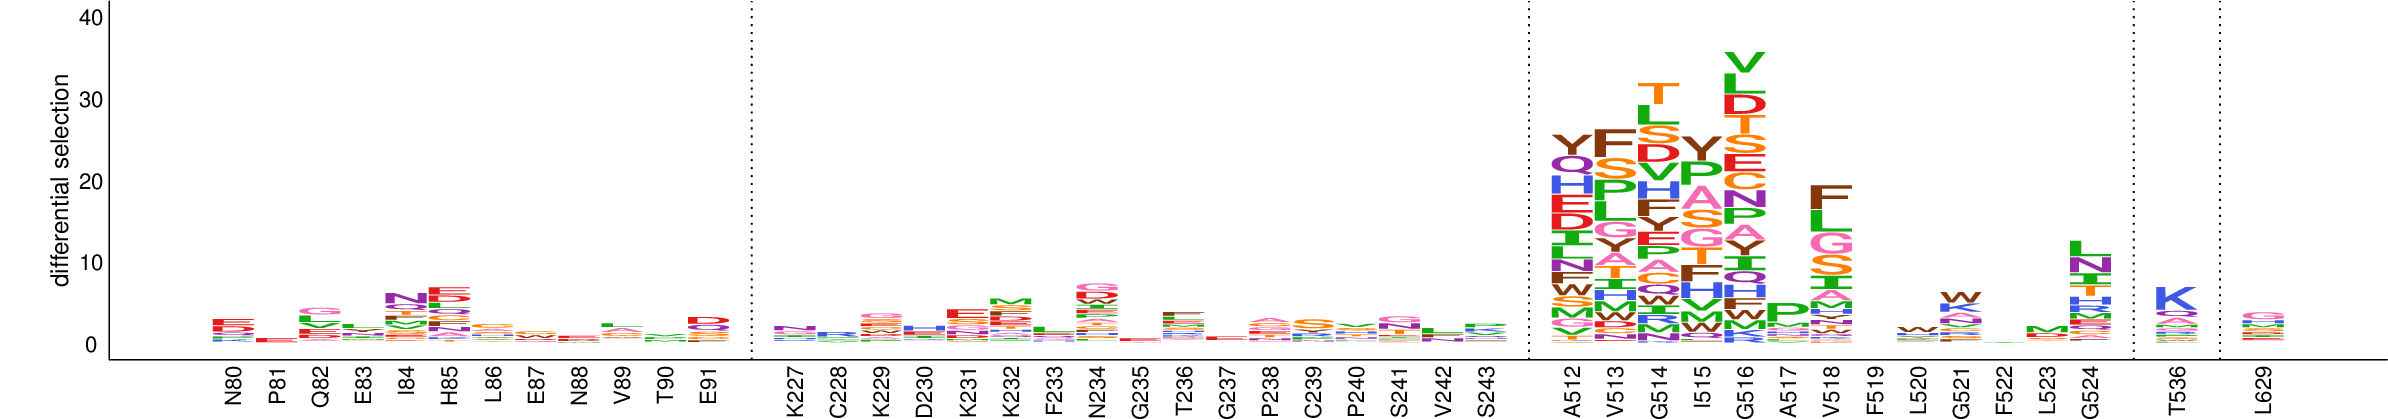

Here is the differential selection for 106E6 at sites of interest


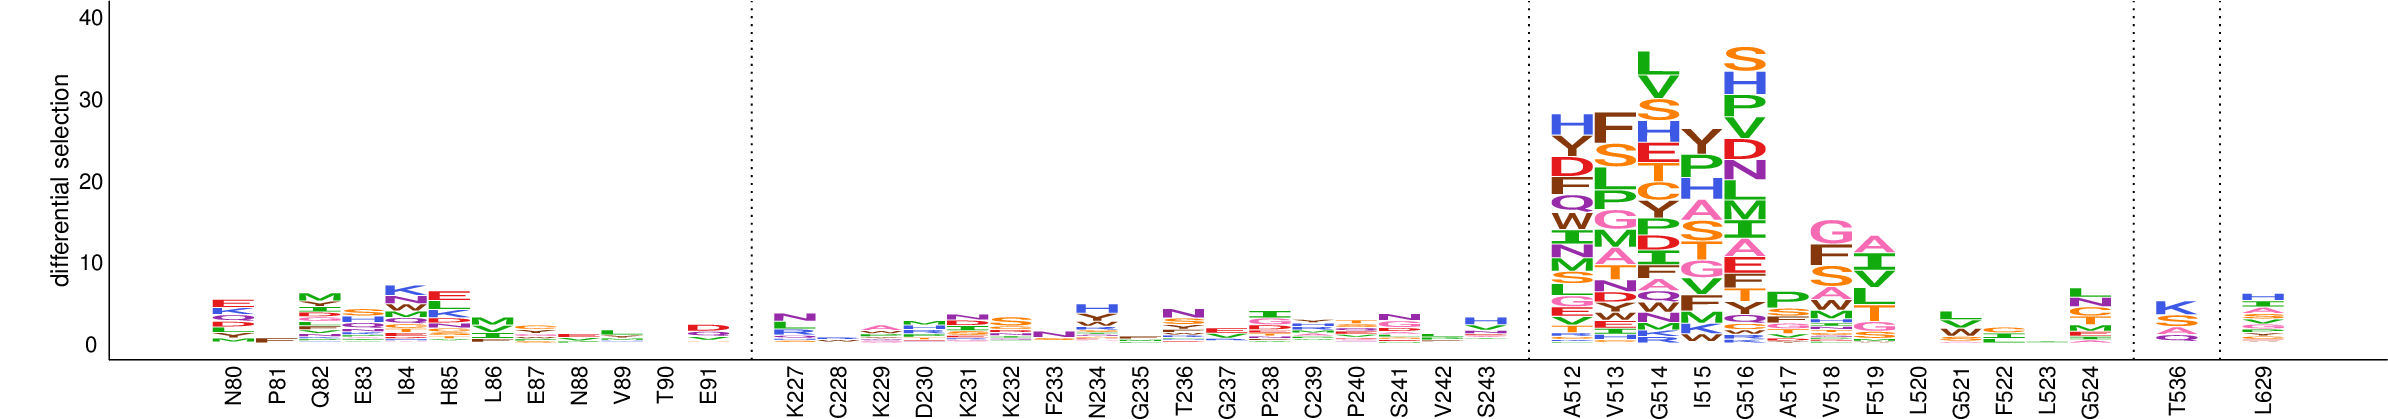

Here is the differential selection for 110D12 at sites of interest


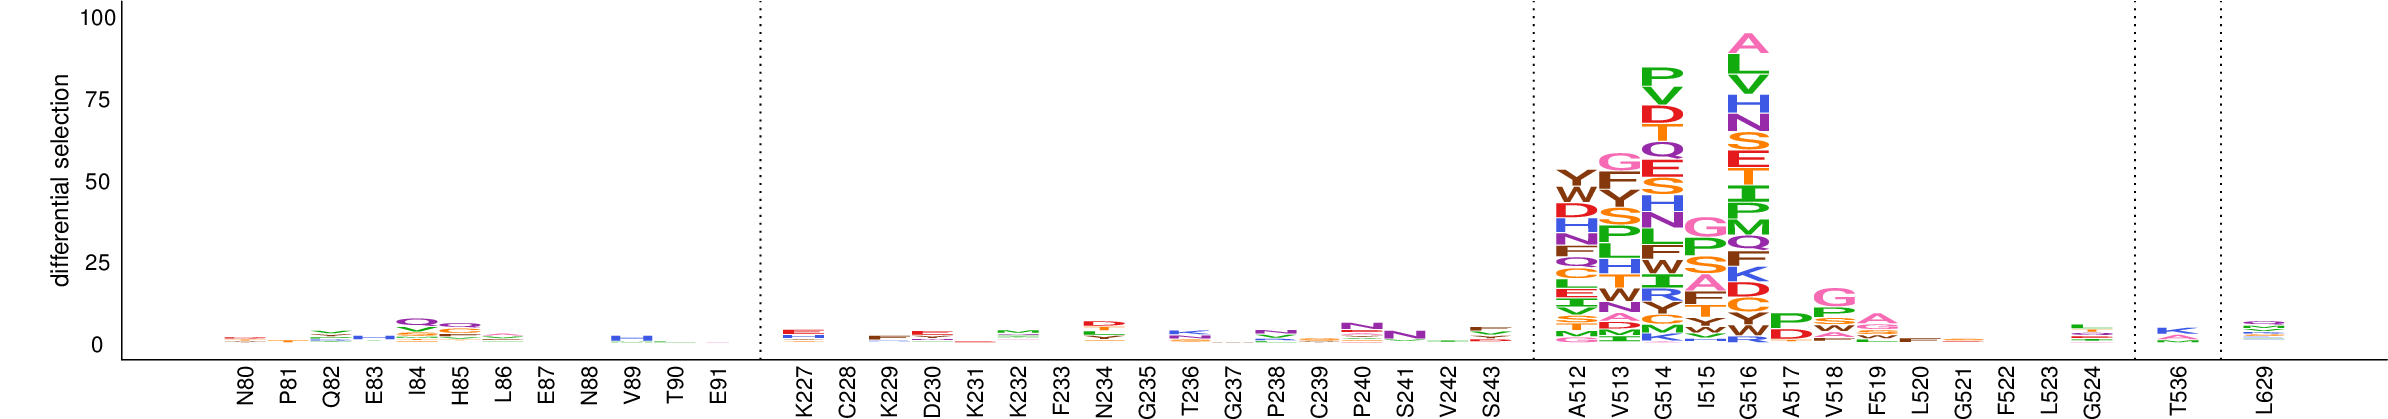

Here is the differential selection for DF1W203 at sites of interest


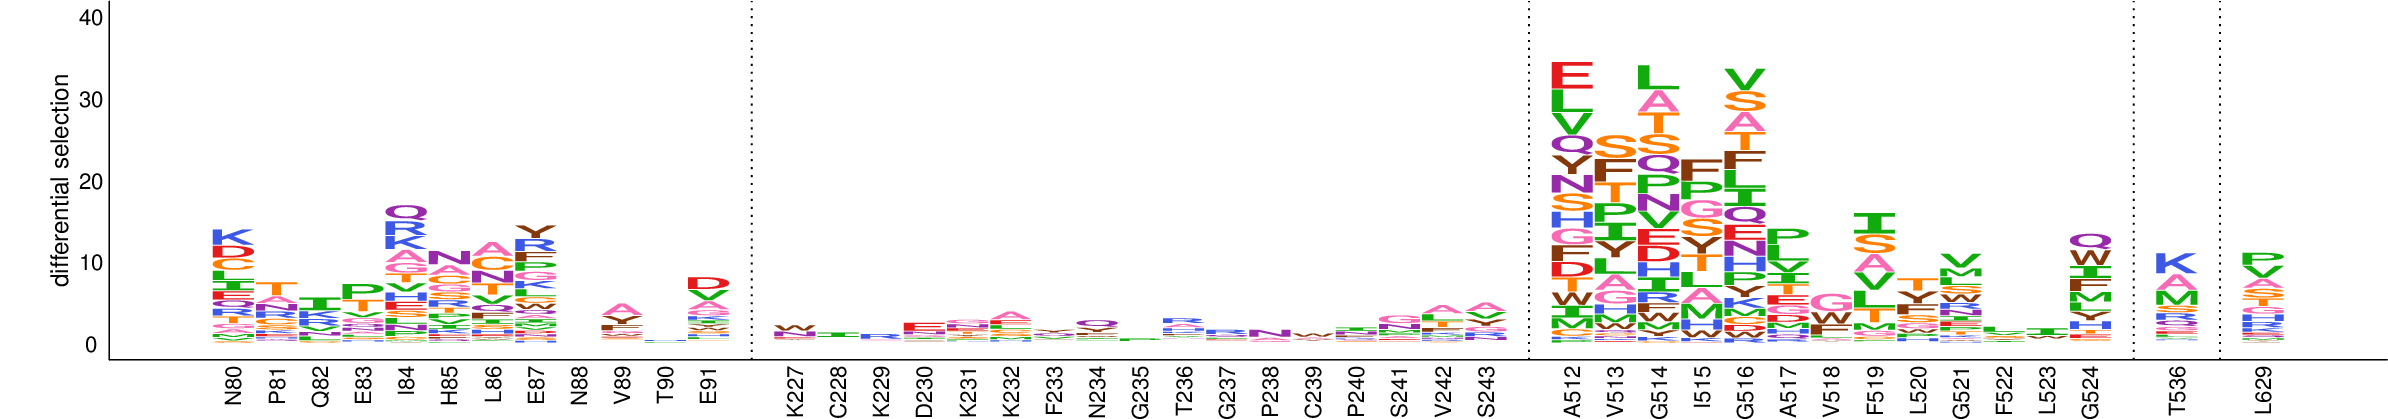

Here is the differential selection for DF1W314 at sites of interest


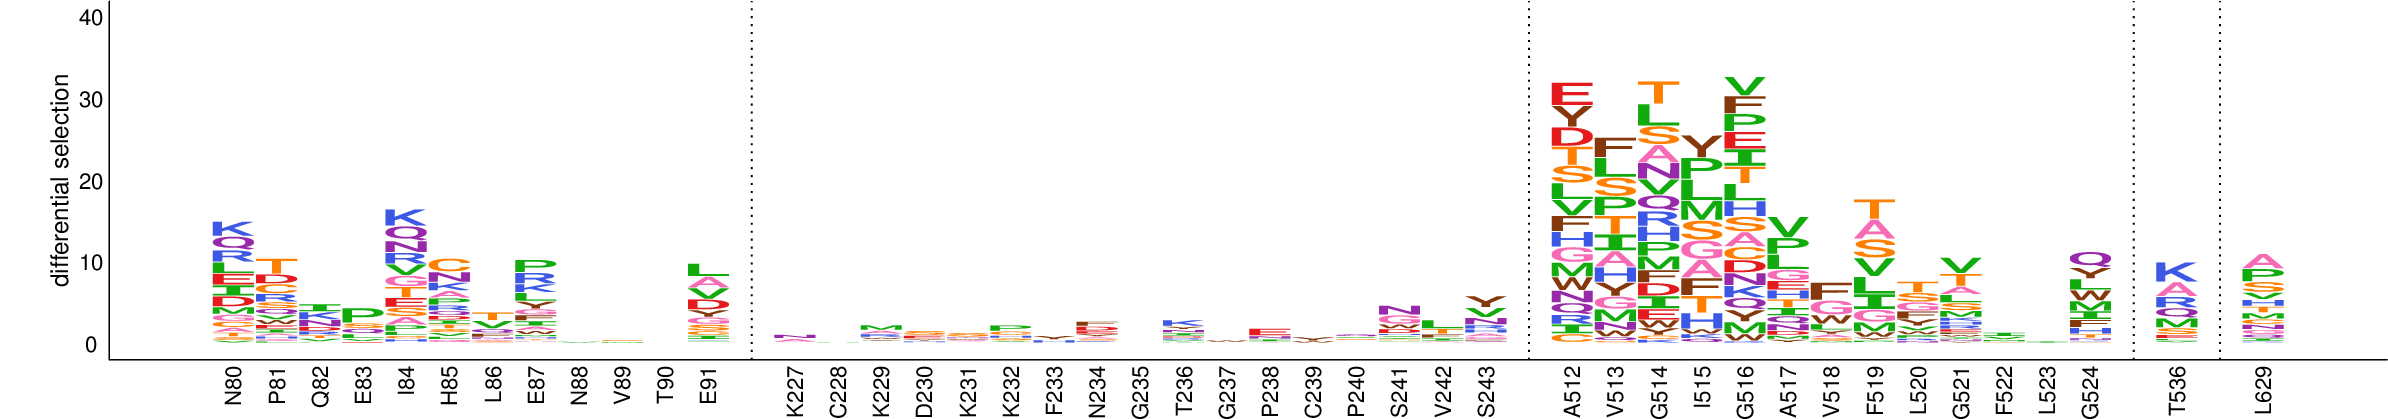

In [71]:
names = ["17D4", "OPV20", "OPV12", "106B6", "106E6", "110D12", "DF1W203", "DF1W314"]

#now, replot zoomed in sections with different y axes

ylimdict = {}
ylimdict['17D4'] = 30
ylimdict['OPV20'] = 70
ylimdict['OPV12'] = 70
ylimdict['106B6'] = 40
ylimdict['106E6'] = 40
ylimdict['110D12'] = 100
ylimdict['DF1W203'] = 40
ylimdict['DF1W314'] = 40



for ab in names:
    epitopesites = keysites_all
    #print(ab)
    max_diffsel = ylimdict[ab]
    mutdiffselfile= mutdiffsel_dict[ab]
    mds_outfile = "./results/diffsel/Figures/{0}_epitope_zoom.pdf".format(ab)
    #pref_outfile = "{0}/{1}_epitope_prefs.pdf".format(epitopelogodir, ab)
    #natseq_outfile = "{0}/{1}_NatSeq.pdf".format(epitopelogodir, ab)
    
    EpitopeDiffselLogoplot("{0}".format(mutdiffselfile), epitopesites, mds_outfile, max_diffsel)
    
    #EpitopeNatSeqLogoplot(natseq_df, epitopesites, natseq_outfile)
    #print(ab)
    print("Here is the differential selection for {0} at sites of interest".format(ab))
    pdflist = []
    showPDF(mds_outfile)



### plot natureal sequence conservation in the epitope

### munge the LANL sequence alignment
`HIV1_FLT_2016_env_PRO.fasta` is the filtered web alignment of all HIV-1 sequences, downoaded Jan 3, 2018 from [`LANL`](https://www.hiv.lanl.gov/cgi-bin/NEWALIGN/align.cgi). We convert the alignment with the function below to amino acid frequencies. 
[./data/HXB2_HIV1_FLT_2016_env_PRO_numbering.csv](./data/HXB2_HIV1_FLT_2016_env_PRO_numbering.csv) is a csv file that contains the HXB2 sequence from the alignment (containing the insertions), with the site labeled according to it's site in the alingment. 
["./data/HXB2_alignment_to_HXB2.csv](./data/HXB2_alignment_to_HXB2.csv) contains a conversion between the alignment site and the HXB2 site. note that insertions sites relative to HXB2 are labled with an x rather than the actual notation (i.e. a, b etc). 

In [83]:
#here, I am redefining dms_tools2.prefs.aafreqsFromAlignment such that it gets rid of sequences that:
#are not the same length 
#mask sites that not IUPAC AAs. 
import Bio.SeqIO
def aafreqsFromAlignment_AD(alignmentfile, codon_to_aa,
        ignore_gaps=True, ignore_stop=True):
    """Get amino-acid frequencies at each site in alignment.

    Args:
        `alignmentfile` (str)
            FASTA file with alignment of proteins or coding sequences.
        `codon_to_aa` (bool)
            If `True`, translate codon alignment to amino acids.
        `ignore_gaps` (bool)
            Ignore gaps when calculating frequencies.
        `ignore_stop` (bool)
            Ignore stop codons when calculating frequencies.

    Returns:
        A `pandas.DataFrame` with columns being `site` (1, 2, ...
        numbering) and other columns being amino acids and values
        giving frequencies in alignment.

    >>> with tempfile.NamedTemporaryFile(mode='w') as f:
    ...     x = f.write('>seq1\\n'
    ...                 'ATGGGGCAG\\n'
    ...                 '>seq2\\n'
    ...                 '---AGGCAG\\n'
    ...                 '>seq3\\n'
    ...                 'ATGTGACAG')
    ...     f.flush()
    ...     aafreqs = aafreqsFromAlignment(f.name, codon_to_aa=True)
    >>> aas_counts = ['M', 'G', 'R', 'Q']
    >>> aas_nocounts = [a for a in dms_tools2.AAS if a not in aas_counts]
    >>> (0 == aafreqs[aas_nocounts].values).all()
    True
    >>> expected_counts = pandas.DataFrame.from_items([
    ...         ('site', [1, 2, 3]), ('M', [1.0, 0.0, 0.0]),
    ...         ('G', [0.0, 0.5, 0]), ('R', [0.0, 0.5, 0.0]),
    ...         ('Q', [0.0, 0.0, 1.0])])
    >>> expected_counts.equals(aafreqs[['site'] + aas_counts])
    True
    """
    # read sequences
    seqs = [s.seq for s in Bio.SeqIO.parse(alignmentfile, 'fasta')]
    if codon_to_aa:
        seqs = [s.translate(gap='-', stop_symbol='*') for s in seqs]
    assert seqs, "No sequences"
    seqlen = len(seqs[0])
    #assert seqlen, "sequences have no length" #commented this and line below out. 
    #assert all([seqlen == len(s) for s in seqs]), "seqs not same length"
    # get character sets
    aas = dms_tools2.AAS.copy()
    skipchars = ["#","?","X","$"] #here I added these other characters
    if ignore_gaps:
        skipchars.append('-')
    else:
        aas.append('-')
    if ignore_stop:
        skipchars.append('*')
    else:
        aas.append('*')
    # tally amino-acid frequencies
    aafreqs = dict([(col, [0] * seqlen) for col in aas])
    aafreqs['site'] = list(range(1, seqlen + 1))
    for s in seqs:
        for (r, aa) in enumerate(s):
            if aa in skipchars:
                continue
            else:
                aafreqs[aa][r] += 1
    # convert to dataframe and change counts to freqs
    aafreqs = pd.DataFrame(aafreqs)
    ncounts = aafreqs[aas].sum(axis=1).astype('float')
    for aa in aas:
        aafreqs[aa] = aafreqs[aa] / ncounts
    return aafreqs[['site'] + aas].fillna(0)

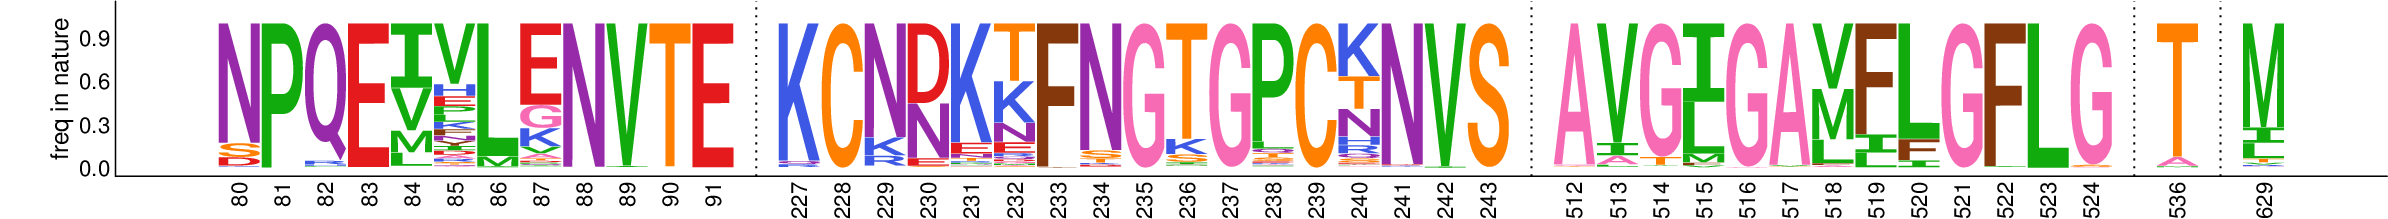

In [85]:
#plot the nat seq conservation
def EpitopeNatSeqLogoplot(HXB2annotated_df, keysites, outfile):
    df = HXB2annotated_df
    df = df.reindex(index=natsort.order_by_index(df.index,natsort.index_natsorted(df.site)))
    df['show'] = df['site'].isin(keysites)
    width = len(keysites) / 2.5
    dms_tools2.rplot.siteSubsetGGSeqLogo(
            logodata=df,
            chars=dms_tools2.AAS,
            plotfile=outfile,
            width=width,
            height=2,
            yname='freq in nature',
            ylimits=(0,1.1),
            )

#preffile = ""
groupM_alignmentfile = "./data/HIV1_FLT_2016_env_PRO.fasta" 
groupM_df = aafreqsFromAlignment_AD(groupM_alignmentfile , codon_to_aa=False, ignore_gaps=True, ignore_stop=True)
alginment_to_HXB2 = pd.read_csv("./data/HXB2_alignment_to_HXB2.csv")
AnnotatedAlignment_df = alginment_to_HXB2.merge(groupM_df, left_on='alignment_site', right_on='site')
AnnotatedAlignment_df = AnnotatedAlignment_df.drop('site', 1)
AnnotatedAlignment_df = AnnotatedAlignment_df.drop('HXB2_AA', 1)
AnnotatedAlignment_df = AnnotatedAlignment_df.drop('alignment_site', 1)
AnnotatedAlignment_df = AnnotatedAlignment_df.rename(columns={'HXB2_site': 'site'})
AnnotatedAlignment_DropInserts_df = AnnotatedAlignment_df[AnnotatedAlignment_df.site.str.contains("x") == False].copy()
natseq_df = AnnotatedAlignment_DropInserts_df.copy()
#EpitopePrefLogoplot(preffile, epitopesites, pref_outfile)
natseq_outfile = "./results/diffsel/Figures/NatSeqCon_epitope_zoom.pdf"
EpitopeNatSeqLogoplot(natseq_df, keysites_all, natseq_outfile)
showPDF(natseq_outfile)

## Now, generate plots for figures for individual antibodies  

### DF1W314, aka  DF1W-a.01, Figure 4
Here, we will plot sites 80-91, 512-524, 536. While there is some escape at site 629, this likely isnt a direct interaction, but rather affecting the epitope from a distance (likely disrupting alpha helix turn?).

In [86]:
keysites = list(range(80, 92)) + list(range(512, 525)) + list(range(536, 537))
keysites = list(map(str, keysites))
#print(keysites)

DF1W314


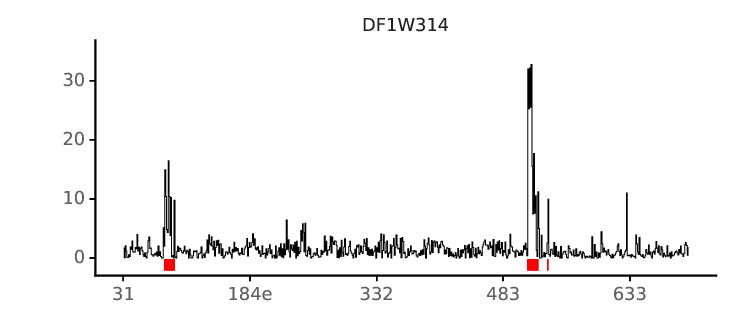

In [87]:
#line plot
ylimdict = {}
ylimdict['17D4'] = 30
ylimdict['OPV20'] = 70
ylimdict['OPV12'] = 70
ylimdict['106B6'] = 40
ylimdict['106E6'] = 40
ylimdict['110D12'] = 100
ylimdict['DF1W203'] = 40
ylimdict['DF1W314'] = 35

#plots = []
singleab = ["DF1W314"]
for antibody in singleab:
    print(antibody)
    plotfile = "./results/diffsel/Figures/{0}-median-positivesitediffsel-annotated-mainfig.pdf".format(antibody)
    epitope_sites = keysites
    significant_sites = []
    highlighted_sites = []
    names = [antibody]
    ylimit = ylimdict[antibody]
    diffselfiles = [sitediffsel_dict[antibody]]
    plotSiteDiffSel_YLimDiff(names, diffselfiles, plotfile, "positive", maxcol=1, underlay_1=epitope_sites, point=significant_sites, highlighted_sites=highlighted_sites, y_lim=ylimit, white_bg=True)
    
    #plots.append(plotfile)
    showPDF(plotfile)
#showPDF(plots)

Here is the differential selection for DF1W314 at sites of interest


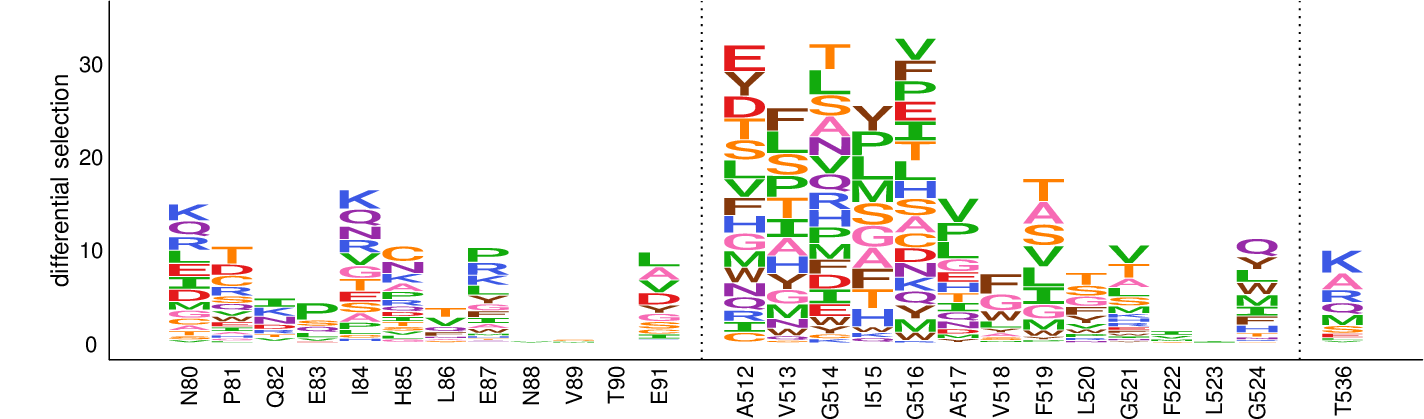

In [88]:
#logo plot

for ab in singleab:
    epitopesites = keysites
    #print(ab)
    max_diffsel = ylimdict[ab]
    mutdiffselfile= mutdiffsel_dict[ab]
    mds_outfile = "./results/diffsel/Figures//{0}_epitopezoom_mainfig.pdf".format(ab)
    #pref_outfile = "{0}/{1}_epitope_prefs.pdf".format(epitopelogodir, ab)
    #natseq_outfile = "{0}/{1}_NatSeq.pdf".format(epitopelogodir, ab)
    
    EpitopeDiffselLogoplot("{0}".format(mutdiffselfile), epitopesites, mds_outfile, max_diffsel)
    
    #EpitopeNatSeqLogoplot(natseq_df, epitopesites, natseq_outfile)
    #print(ab)
    print("Here is the differential selection for {0} at sites of interest".format(ab))
    pdflist = []
    showPDF(mds_outfile)

### 106E6, aka , Figure 6. alternativeky, we could be plotting 110D12?
Here, we will plot sites 512-524.

In [89]:
keysites2 = list(range(512, 525)) 
keysites2 = list(map(str, keysites2))
#print(keysites2)

106E6


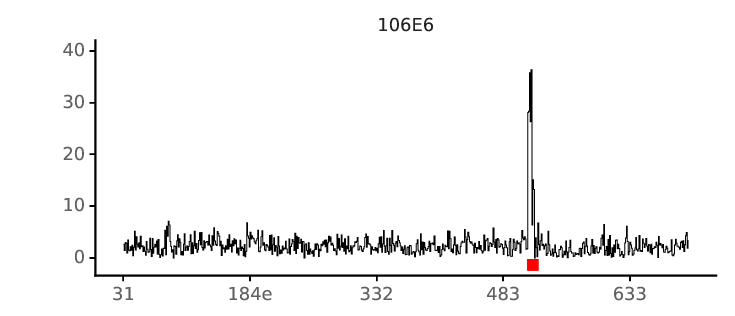

In [90]:
#line plot
singleab = ["106E6"]
for antibody in singleab:
    print(antibody)
    plotfile = "./results/diffsel/Figures/{0}-median-positivesitediffsel-annotated-mainfig.pdf".format(antibody)
    epitope_sites = keysites2
    significant_sites = []
    highlighted_sites = []
    names = [antibody]
    ylimit = ylimdict[antibody]
    diffselfiles = [sitediffsel_dict[antibody]]
    plotSiteDiffSel_YLimDiff(names, diffselfiles, plotfile, "positive", maxcol=1, underlay_1=epitope_sites, point=significant_sites, highlighted_sites=highlighted_sites, y_lim=ylimit, white_bg=True)
    
    #plots.append(plotfile)
    showPDF(plotfile)
#showPDF(plots)


Here is the differential selection for 106E6 at sites of interest


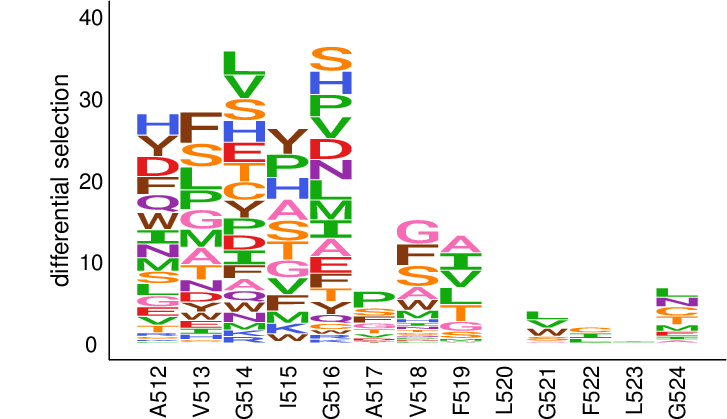

In [91]:
#logoplot
for ab in singleab:
    epitopesites = keysites2
    #print(ab)
    max_diffsel = ylimdict[ab]
    mutdiffselfile= mutdiffsel_dict[ab]
    mds_outfile = "./results/diffsel/Figures//{0}_epitopezoom_mainfig.pdf".format(ab)
    #pref_outfile = "{0}/{1}_epitope_prefs.pdf".format(epitopelogodir, ab)
    #natseq_outfile = "{0}/{1}_NatSeq.pdf".format(epitopelogodir, ab)
    
    EpitopeDiffselLogoplot("{0}".format(mutdiffselfile), epitopesites, mds_outfile, max_diffsel)
    
    #EpitopeNatSeqLogoplot(natseq_df, epitopesites, natseq_outfile)
    #print(ab)
    print("Here is the differential selection for {0} at sites of interest".format(ab))
    pdflist = []
    showPDF(mds_outfile)

### 17D4, aka aka A12V163-17D4, Figure 7
Here, we will plot sites 84-91, 229-243, 512-524. While there is some escape at site 629, this likely isnt a direct interaction, but rather affecting the epitope from a distance (likely disrupting alpha helix turn?).

In [79]:
keysites3 = list(range(84, 92)) + list(range(229, 244)) + list(range(512, 525)) 
keysites3 = list(map(str, keysites3))
#print(keysites3)

17D4


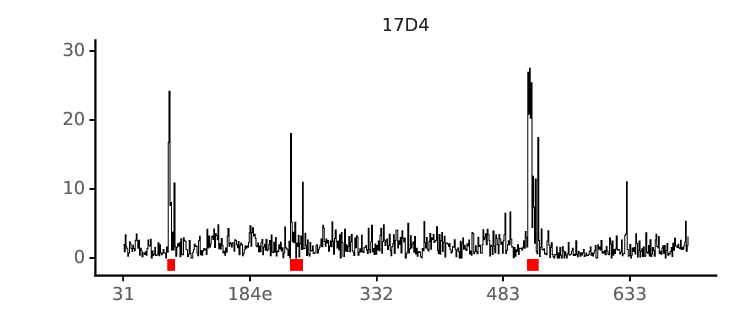

In [80]:
#line plot
#line plot
singleab = ["17D4"]
for antibody in singleab:
    print(antibody)
    plotfile = "./results/diffsel/Figures/{0}-median-positivesitediffsel-annotated-mainfig.pdf".format(antibody)
    epitope_sites = keysites3
    significant_sites = []
    highlighted_sites = []
    names = [antibody]
    ylimit = ylimdict[antibody]
    diffselfiles = [sitediffsel_dict[antibody]]
    plotSiteDiffSel_YLimDiff(names, diffselfiles, plotfile, "positive", maxcol=1, underlay_1=epitope_sites, point=significant_sites, highlighted_sites=highlighted_sites, y_lim=ylimit, white_bg=True)
    
    #plots.append(plotfile)
    showPDF(plotfile)
#showPDF(plots)

Here is the differential selection for 17D4 at sites of interest


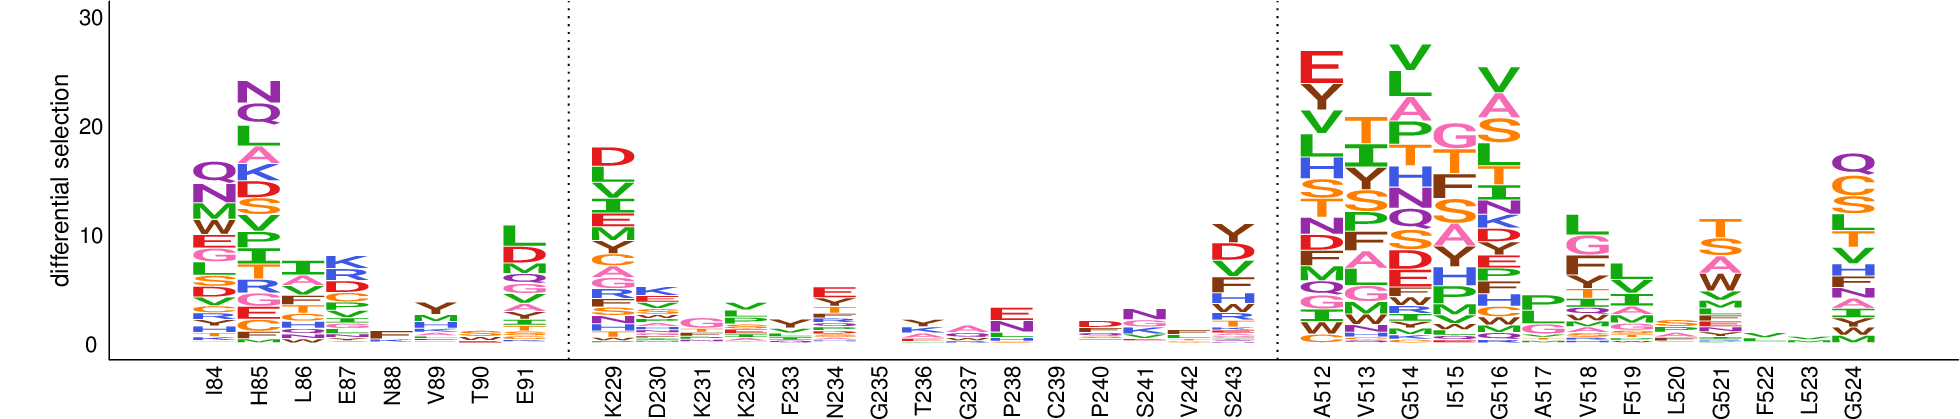

In [81]:
#logoplot
for ab in singleab:
    epitopesites = keysites3
    #print(ab)
    max_diffsel = ylimdict[ab]
    mutdiffselfile= mutdiffsel_dict[ab]
    mds_outfile = "./results/diffsel/Figures//{0}_epitopezoom_mainfig.pdf".format(ab)
    #pref_outfile = "{0}/{1}_epitope_prefs.pdf".format(epitopelogodir, ab)
    #natseq_outfile = "{0}/{1}_NatSeq.pdf".format(epitopelogodir, ab)
    
    EpitopeDiffselLogoplot("{0}".format(mutdiffselfile), epitopesites, mds_outfile, max_diffsel)
    
    #EpitopeNatSeqLogoplot(natseq_df, epitopesites, natseq_outfile)
    #print(ab)
    print("Here is the differential selection for {0} at sites of interest".format(ab))
    pdflist = []
    showPDF(mds_outfile)

### Map selection onto structure

In [118]:

from colour import Color
import pandas as pd
import pandas as pd
from io import StringIO
colors = ('#fafafa', '#ff0000')
def MapDiffselColorToSite(diffselfile, scriptfile, script_type='pymol', 
                          map_type='abs_diffsel', colors = colors, sitecolorfile=None,
                          script_preamble=False, restrict_to_chain=False, script_postamble=False, abname=None):
    '''Produces a colormapping based on differential selection and writes a script for `pymol` or `chimera`
    to color a structure by this colormapping.
    
    Uses the data in *diffselfile*, which can be either a mutdiffsel or a sitediffsel file, 
    depending on the specified *map_type*. 
    
    Writes a python script to *scriptfile* for the molecular visualization program specified 
    in *script_type* (either `pymol` or `chimera`).
    
    *colors* is a list of two colors defined by hex or r,g,b codes.
    
    How the mapping from differential selection to color is determined is specified by the 
    following choices for *map_type*:
    
        * `abs_diffsel`: plot total absolute differential selection at each site. 
        Total absolute differential selection will be converted to color by interpolating between 
        the two *colors*, which will be used to show the minimum and maximum values, respectively.
        Requries *diffselfile* to be a '*sitediffsel.txt' file.
        
        * `positive_diffsel`: plot the absolute positive selection at each site. 
        Absolute positive differential selection will be converted to color by interpolating between 
        the two *colors*, which will be used to show the minimum and maximum values, respectively.
        Requries *diffselfile* to be a '*sitediffsel.txt' file.
        
        * `negative_diffsel`: plot the absolute negative selection at each site. 
        Absolute negative differential selection will be converted to color by interpolating between 
        the two *colors*, which will be used to show the (absolute) minimum and maximum values, respectively.
        Requries *diffselfile* to be a '*sitediffsel.txt' file.
        
        * `max_pos_mutdiffsel`: plot the maximum positive mutdiffsel at each site (the value for the most 
        strongly enriched mutation at each site).
        Requries *diffselfile* to be a '*mutdiffsel.txt' file.
    
    If you want to restrict the recoloring to a single chain, specify the name of the chain to color to *restrict_to_chain*.
        
    Optionally, provide a path for a *sitecolorfile* to which the (site, hexcolor, rgbcolor) mappings are
    written.
    
    Optionally, if a *script_preamble* is provided, it is written to the top of the script before the 
    commands for colormapping. This may be a useful place to add other pymol or chimera commands to load 
    the pdb file, orient the view, etc.
    '''

    # read in the data from the diffselfile:
    df = pd.read_csv(diffselfile)
    df = df.dropna()
    
    #drop rows that are insertions relative to HXB2. This is not ideal, but done to ensure the coloring script works. note insertions relative to HXB2 in the sturcture are not colored according to diffsel metrics.
    
    df = df[df.site.apply(lambda x: x.isnumeric())]
    column_names = list(df)
   
    if column_names == ['site', 'wildtype', 'mutation', 'mutdiffsel'] or column_names == ['site', 'wildtype', 'mutation', 'mutfracsurvive']:
        filetype = 'mutdiffsel'
    elif column_names == ['site', 'abs_diffsel', 'positive_diffsel', 'negative_diffsel', 'max_diffsel', 'min_diffsel']:
        filetype = 'sitediffsel' 
    else:

        raise ValueError('diffsel file does not have appropriate set of column identifiers for {0}'.format(column_names))
    
    # establish the color spectrum in hex and rgb.
    n_subdivisions = 500 # the color spectrum will be divided into this many discrete colors
    color1 = Color(colors[0])
    color2 = Color(colors[1])
    hex_spectrum = [c.hex for c in color1.range_to(color2, n_subdivisions)]
    hex_spectrum_dict = dict([(i, hex_spectrum[i]) for i in range(len(hex_spectrum))]) 
    rgb_spectrum = [c.rgb for c in color1.range_to(color2, n_subdivisions)]
    rgb_spectrum_dict = dict([(i, rgb_spectrum[i]) for i in range(len(rgb_spectrum))])
    
    # generate the site ==> colorindex mapping based on *map_type*:
    if map_type == 'abs_diffsel':
        assert filetype == 'sitediffsel'
        min_diff = df.min()['abs_diffsel']  
        max_diff = df.max()['abs_diffsel']  # the min and max will be mapped to color1 and color2, respectively
        range_diff = max_diff - min_diff
        df['colorindex'] =  (df.abs_diffsel - min_diff)/range_diff*(n_subdivisions-1)
        
    elif map_type == 'negative_diffsel':
        assert filetype == 'sitediffsel'
        abs_neg_col = abs(df['negative_diffsel'])
        df = df.assign(abs_neg=abs_neg_col)
        min_diff = df.min()['abs_neg']  
        max_diff = df.max()['abs_neg']  # the min and max will be mapped to color1 and color2, respectively
        range_diff = max_diff - min_diff
        df['colorindex'] =  (df.abs_neg - min_diff)/range_diff*(n_subdivisions-1)
            
    elif map_type == 'positive_diffsel':
        assert filetype == 'sitediffsel'
        abs_pos_col = abs(df['positive_diffsel'])
        df = df.assign(abs_pos=abs_pos_col)
        min_diff = df.min()['abs_pos']  
        max_diff = df.max()['abs_pos']  # the min and max will be mapped to color1 and color2, respectively
        range_diff = max_diff - min_diff
        df['colorindex'] =  (df.abs_pos - min_diff)/range_diff*(n_subdivisions-1)
    
    elif map_type == 'max_pos_mutdiffsel':
        assert filetype == 'mutdiffsel'
        # sort mutdiffsel file by diffsel in case it wasn't already:
        df.sort_values('mutdiffsel', ascending=False, inplace=True)
        # a new dataframe to only store the max mutdiffsel from each site
        newdf = pd.DataFrame(columns=['site', 'wildtype', 'mutation', 'mutdiffsel']) 
        for row in df.itertuples():
            if not any(newdf['site'].astype(int) == int(row[1])):
                newdf = newdf.append(pd.DataFrame([row[1:]], columns = ['site', 'wildtype', 'mutation', 'mutdiffsel']))
        
        newdf['site'] = newdf['site'].apply(int)
        
        
        # replace negative values with zero at sites where there was no positive selection:
        #newdf = newdf.clip(lower=0) #old
        newdf['site'] = newdf['site'].clip(lower=0) #new
        min_diff = newdf.min()['mutdiffsel']  
        max_diff = newdf.max()['mutdiffsel']  # the min and max will be mapped to color1 and color2, respectively
        range_diff = max_diff - min_diff
        newdf['colorindex'] =  (newdf.mutdiffsel - min_diff)/range_diff*(n_subdivisions-1)
        df = newdf

    else:
        raise ValueError("%s is not a recognized map_type." % map_type)
        
    # add a column for colors for each site
    df['colorindex'] = df['colorindex'].astype(int) # round to nearest index
    df['hex'] = df['colorindex'].map(hex_spectrum_dict)
    df['rgb'] = df['colorindex'].map(rgb_spectrum_dict)        
    site_color_mapping = pd.concat([df['site'], df['hex'], df['rgb']], axis=1)
    
    if sitecolorfile:
        site_color_mapping.to_csv(sitecolorfile, index=False)
    
    # write out the script to *scriptfile*:
    f = open(scriptfile, 'w')
    
    if script_preamble:
        preamblef = open(script_preamble, 'r')
        for line in preamblef:
            f.write(line)
    
    if script_type == 'chimera':
        f.write("from chimera import runCommand\n")
        for i in range(len(df.index)):
            f.write("runCommand(color %s :%s)" % (site_color_mapping.iloc[i]['hex'], site_color_mapping.iloc[i]['site']) )
    elif script_type == 'pymol':
        for i in range(len(df.index)):
            rgblist = [min(1, c) for c in site_color_mapping.iloc[i]['rgb']]
            f.write("cmd.set_color(\'color%s\', \'%s\')\n" % (site_color_mapping.iloc[i]['site'], rgblist))
            if restrict_to_chain:
                f.write("cmd.color(\'color%s\', \'chain %s and resi %s\')\n" % (site_color_mapping.iloc[i]['site'], restrict_to_chain, site_color_mapping.iloc[i]['site']))
            else:
                f.write("cmd.color(\'color%s\', \'resi %s\')\n" % (site_color_mapping.iloc[i]['site'], site_color_mapping.iloc[i]['site']))
    else:
        raise ValueError("script_type must be chimera or pymol.")
    
    if script_postamble:
        postamblef = open(script_postamble, 'r')
        f.write('abname = "{0}"'.format(abname))
        for line in postamblef:
            f.write(line)
    
    f.close()

In [99]:
pymoldir = "./results/diffsel/wtDNA_ctrl/pymol/"
if not os.path.isdir(pymoldir):
    os.mkdir(pymoldir)

In [121]:
names = ["17D4", "OPV20", "OPV12", "106B6", "106E6", "110D12", "DF1W203", "DF1W314"]

for ab in names:
    mutdiffselfile= './results/diffsel/wtDNA_ctrl/summary_{0}-medianmutdiffsel.csv'.format(ab)
    scriptfile= './results/diffsel/wtDNA_ctrl/pymol/summary_{0}-median_ColorMaxPositive.py'.format(ab)
    MapDiffselColorToSite(mutdiffselfile, scriptfile, script_type='pymol', map_type='max_pos_mutdiffsel')
    
    sitediffselfile= './results/diffsel/wtDNA_ctrl/summary_{0}-mediansitediffsel.csv'.format(ab)

    scriptfile= './results/diffsel/wtDNA_ctrl/pymol/summary_{0}-median_ColorPositiveDiff.py'.format(ab)
    MapDiffselColorToSite(sitediffselfile, scriptfile, script_type='pymol', map_type='positive_diffsel')
    scriptfile= './results/diffsel/wtDNA_ctrl/pymol/summary_{0}-median_ColorAbsDiff.py'.format(ab)
    MapDiffselColorToSite(sitediffselfile, scriptfile, script_type='pymol', map_type='abs_diffsel')
    scriptfile= './results/diffsel/wtDNA_ctrl/pymol/summary_{0}-median_ColorNegDiff.py'.format(ab)
    MapDiffselColorToSite(sitediffselfile, scriptfile, script_type='pymol', map_type='negative_diffsel')

Now, I will generate scripts that take picture of PDB:5I8H, colored according to positivesitediffsel for each antibody. 
    
Change from VRC34 - remove all fabs, show all surface. view is fine. 

In [119]:
names = ["17D4", "OPV20", "OPV12", "106B6", "106E6", "110D12", "DF1W203", "DF1W314"]


preamble = "./data/General5I8H-preamble.txt"
postamble = "./data/General5I8H-postamble.txt"

for ab in names:
    Name = ab
    sitediffselfile= './results/diffsel/wtDNA_ctrl/summary_{0}-mediansitediffsel.csv'.format(ab)
    scriptfile= './results/diffsel/wtDNA_ctrl/pymol/Fig5I8H_{0}-median_ColorPositiveDiff.py'.format(ab)
    MapDiffselColorToSite(sitediffselfile, scriptfile, script_type='pymol', map_type='positive_diffsel', script_preamble=preamble, script_postamble=postamble, abname=Name)

In [ ]:
preamble = "./data/General5I8H-preamble.txt"
postamble = "./data/General5I8H-Zoom-postamble.txt"

for ab in names:
    Name = "Zoom_{0}".format(ab)
    sitediffselfile= './results/diffsel/wtDNA_ctrl/summary_{0}-mediansitediffsel.csv'.format(ab)
    scriptfile= './results/diffsel/wtDNA_ctrl/pymol/Zoom_Fig5I8H_{0}-median_ColorPositiveDiff.py'.format(ab)
    MapDiffselColorToSite(sitediffselfile, scriptfile, script_type='pymol', map_type='positive_diffsel', script_preamble=preamble, script_postamble=postamble, abname=Name)